# In this notebook

 * [Analyse des résidus par 15 min et par station (obs, pred, trend)](#link1)  
 * [Analyse des résidus par jour et par station (observation et prévisions agrégées par jour)](#link2)
 * [Agrégation de la prévision par mois, calcul des résidus et affichage (heatmap)](#link3)

In [1]:
import numpy as np
import pandas as pd
import sys 
sys.path.insert(0, '/home/toque/work/forecast/utils/')
import utils
import utils_date

import itertools
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace import sarimax

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import seaborn
seaborn.set_style('whitegrid')

In [2]:
name_list = pd.read_csv('/home/toque/data2/montreal/stm/data/station_info.csv')['stop_name'].values
dict_id_name = dict([(i,j) for i,j in pd.read_csv('/home/toque/data2/montreal/stm/data/station_info.csv')[['stop_id','stop_name']].values])

In [3]:
pred = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/mt_rf_uni_inverted_eventsALLreduce_OPTIMALL/2015-01-01_2017-12-31.csv')
obs = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv')
date_list = obs.set_index('Datetime')[[]].join(pred.set_index('Datetime')[[]]).index.values

<a id='link1'></a>
# Analyse des résidus par 15 min et par station (obs, pred, trend)

Frequence de la tendance : 365\*96   
Analyse de:
 * la prévision
 * des résidus
 * la tendance des observations
 * des résidus moins la tendance des observation
 * la tendance des résidus  

La corrélation entre la tendance des résidus et la tendance des observations est pour la majorité des stations très haute. Plus les valeurs à prédire sont hautes plus les résidus sont haut et inversement (c'est logique).

--------------------------------------------- Station 11 (1/5)---------------------------------------------------


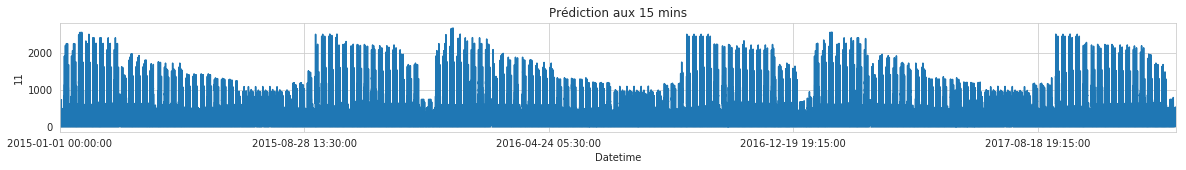

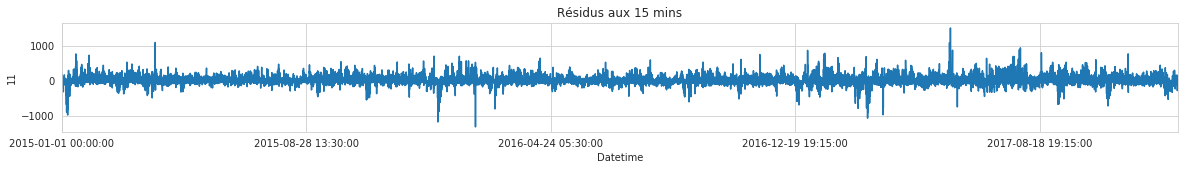

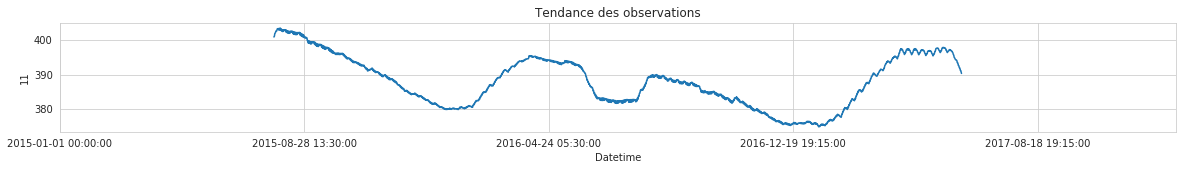

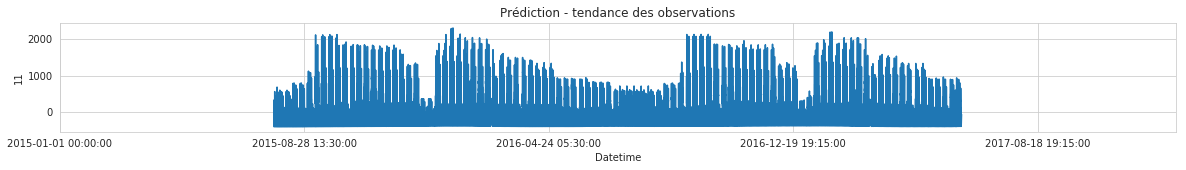

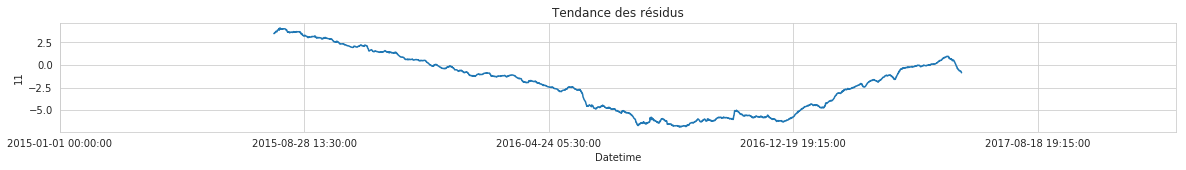

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.965

--------------------------------------------- Station 32 (2/5)---------------------------------------------------


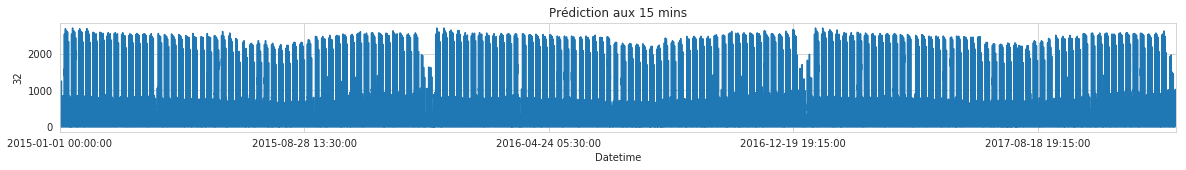

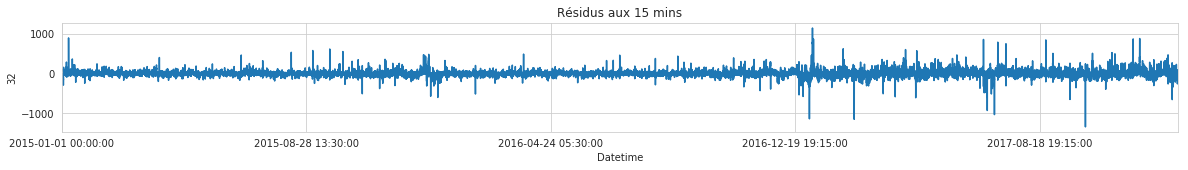

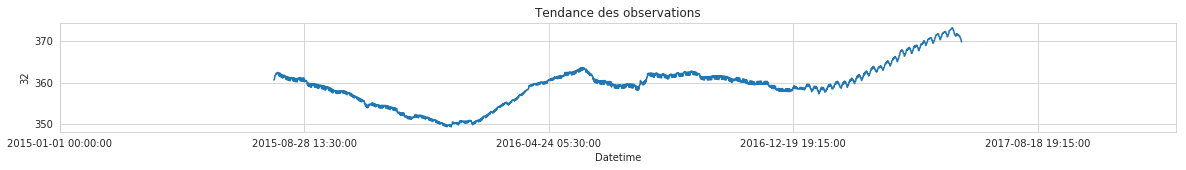

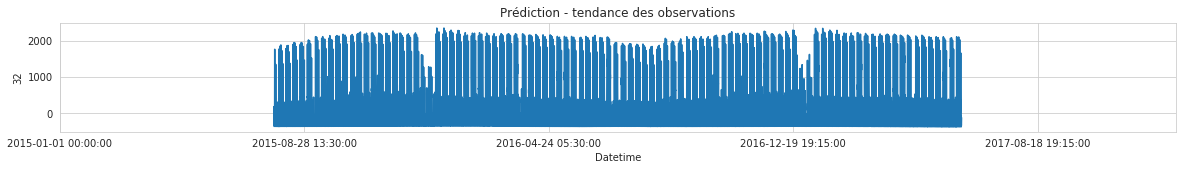

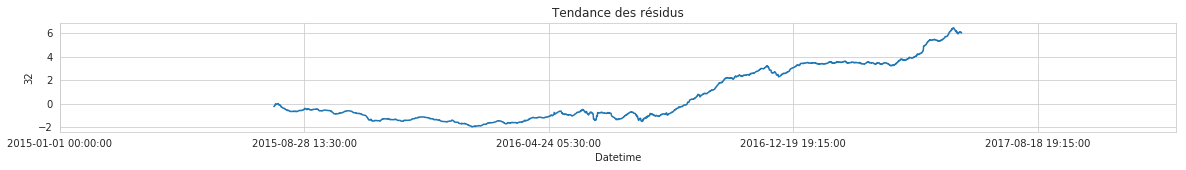

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.835

--------------------------------------------- Station 34 (3/5)---------------------------------------------------


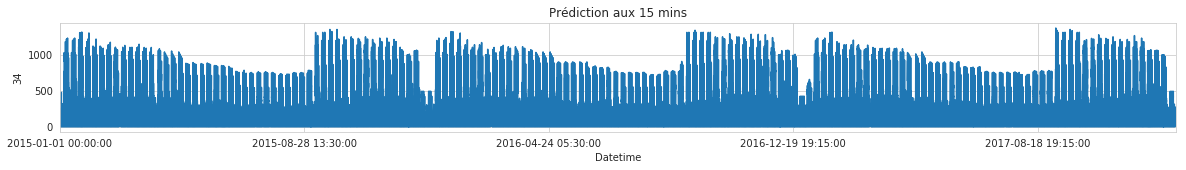

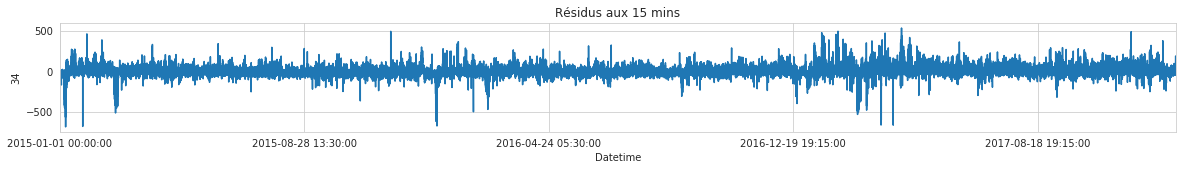

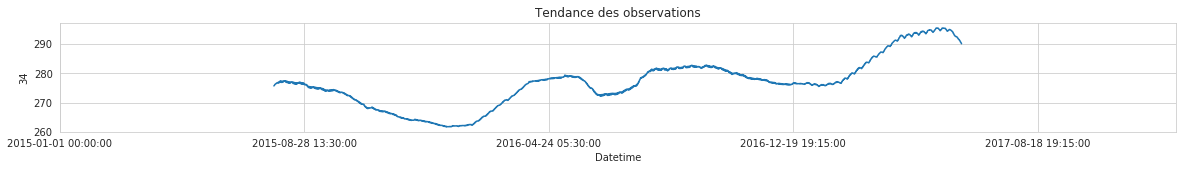

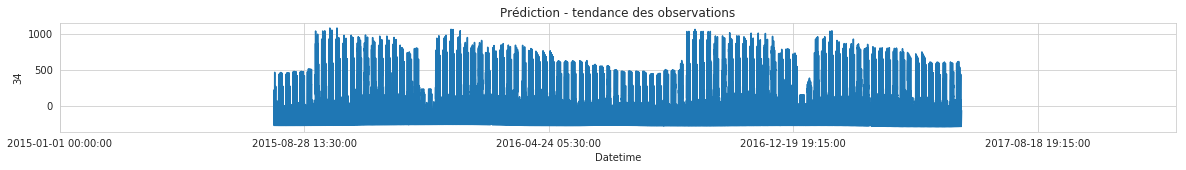

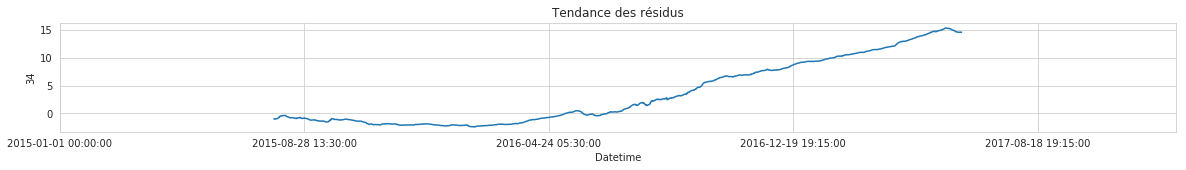

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.952

--------------------------------------------- Station 15 (4/5)---------------------------------------------------


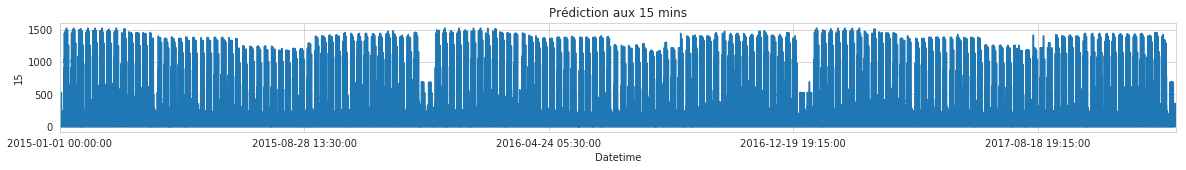

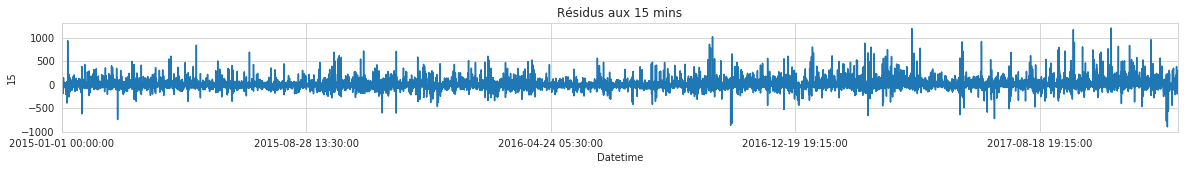

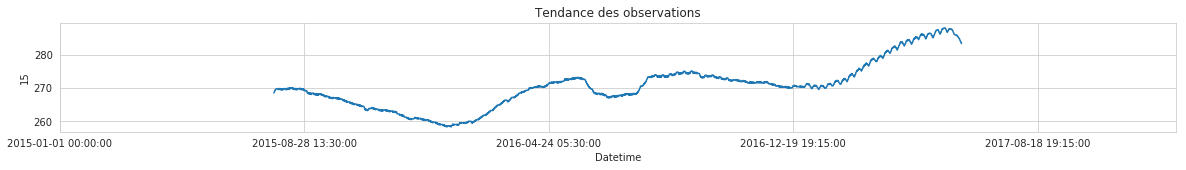

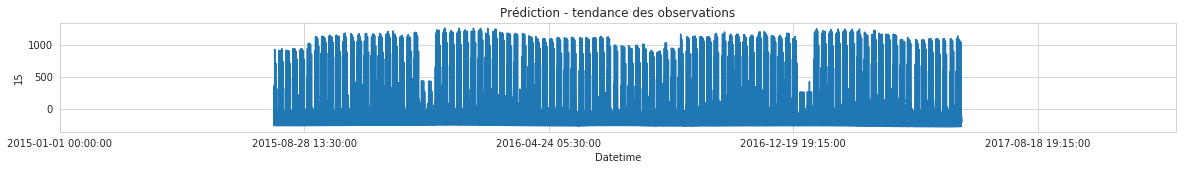

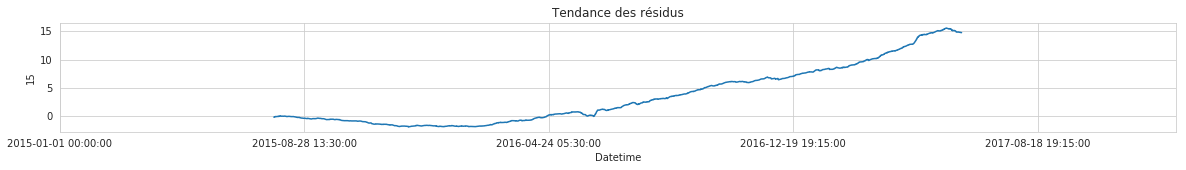

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.972

--------------------------------------------- Station 44 (5/5)---------------------------------------------------


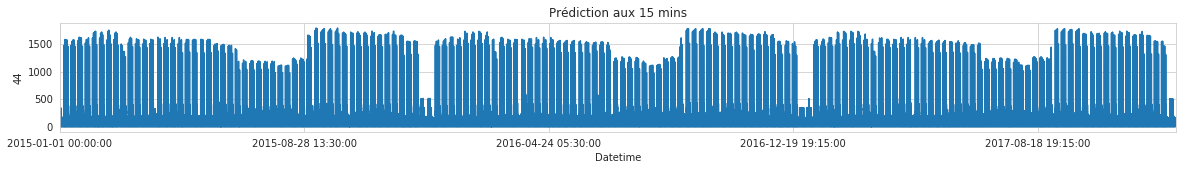

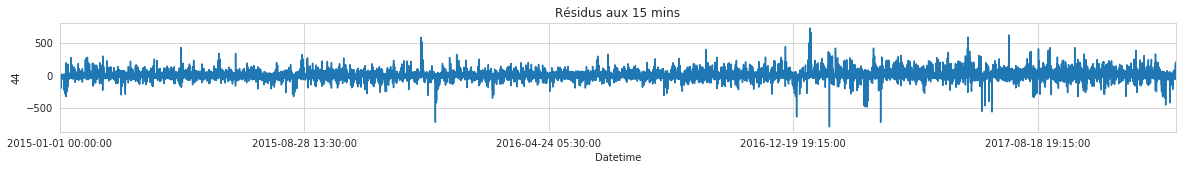

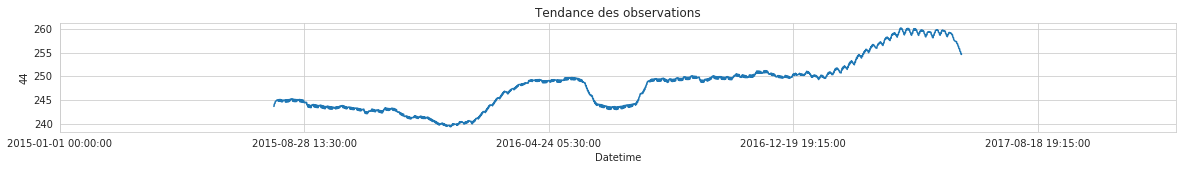

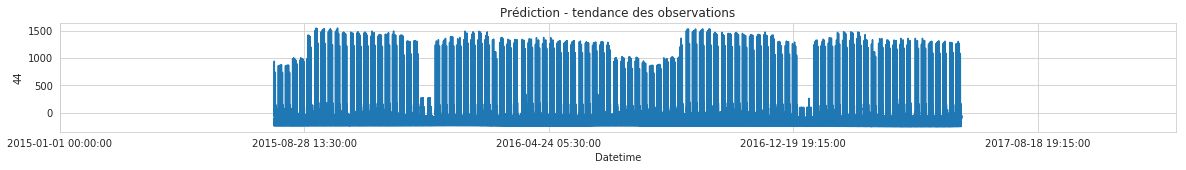

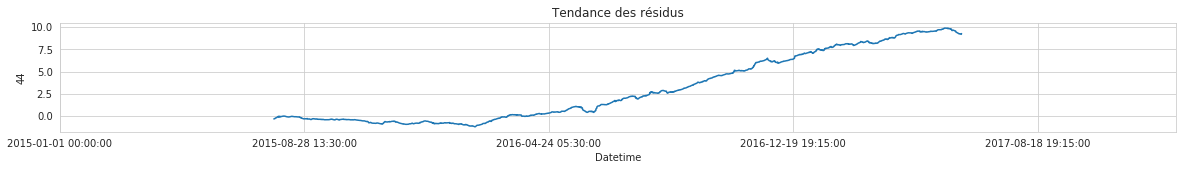

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.916



In [7]:
residus = (obs.set_index('Datetime').loc[date_list] - pred.set_index('Datetime').loc[date_list]).reset_index()

freq = 365*96
corr_list = []
nts= 5
for idx,ts in enumerate(obs.set_index('Datetime').columns.values[:nts]):
    print('--------------------------------------------- Station {} ({}/{})---------------------------------------------------'.format(ts,idx+1,len(obs.set_index('Datetime').columns.values[:nts])))
 
        
    #fig,ax = plt.subplots(figsize=(20,2))
    #obs.set_index('Datetime').loc[date_list][ts].plot(ax=ax)
    #plt.ylabel(ts)
    #plt.title('observation aux 15 mins')
    #plt.show()
    
    
    fig,ax = plt.subplots(figsize=(20,2))
    pred.set_index('Datetime').loc[date_list][ts].plot(ax=ax)
    plt.ylabel(ts)
    plt.title('Prédiction aux 15 mins')
    plt.show()
    
    fig,ax = plt.subplots(figsize=(20,2))
    residus.set_index('Datetime')[ts].plot(ax=ax)
    plt.ylabel(ts)
    plt.title('Résidus aux 15 mins')
    plt.show()
    
    result_obs = seasonal_decompose(obs.set_index('Datetime').loc[date_list][ts], model='additive', freq=freq)
    fig,ax = plt.subplots(figsize=(20,2))
    result_obs.trend.plot(ax=ax, legend = False)
    plt.ylabel(ts)
    plt.title('Tendance des observations')
    plt.show()
    
    date_list_trend = result_obs.trend.dropna().index.values
    
    rf_moins_trend = obs[['Datetime']].set_index('Datetime').loc[date_list].join(pred.set_index('Datetime').loc[date_list_trend][ts] - result_obs.trend.loc[date_list_trend])
    fig,ax = plt.subplots(figsize=(20,2))
    rf_moins_trend.plot(ax=ax, legend = False)
    plt.ylabel(ts)
    plt.title('Prédiction - tendance des observations')
    plt.show()
    
    
    result_pred = seasonal_decompose(residus.set_index('Datetime').loc[date_list][ts], model='additive', freq=freq)
    fig,ax = plt.subplots(figsize=(20,2))
    result_pred.trend.plot(ax=ax, legend = False)
    plt.ylabel(ts)
    plt.title('Tendance des résidus')
    plt.show()
    
    
    corr_trend_obs_pred = np.corrcoef(result_obs.trend.dropna().loc['2017':].values,
                                      result_pred.trend.dropna().loc['2017':].values)[0][1]
    print('La corrélation entre la tendance des résidus de prévision et la tendance des observations est : {:.3f}\n'.format(corr_trend_obs_pred))

    corr_list.append(corr_trend_obs_pred)


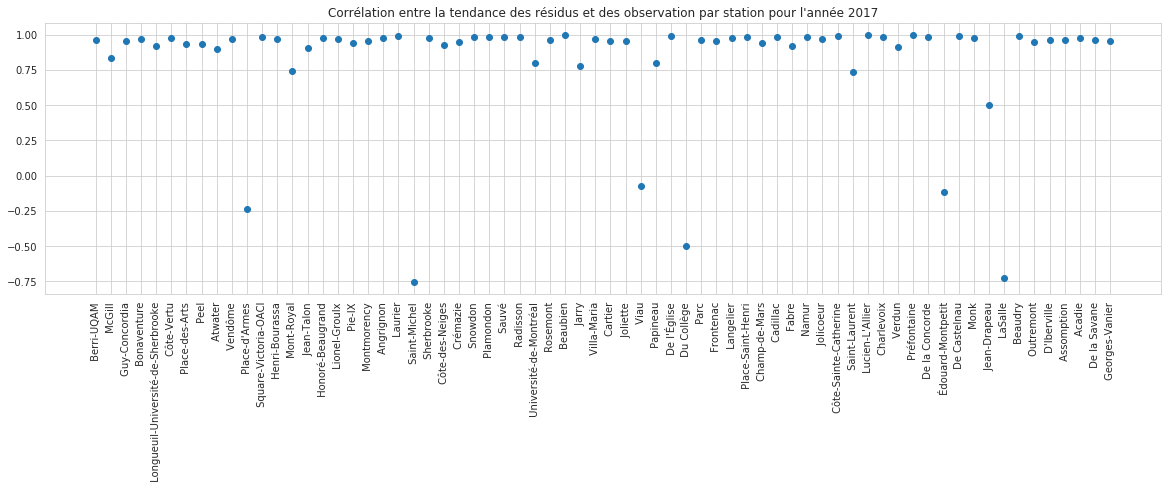

In [5]:
fig,ax = plt.subplots(figsize = (20,5))
plt.plot(corr_list, 'o')
plt.xticks(np.arange(len(corr_list)), [i[7:] for i in name_list], rotation=90)
plt.title("Corrélation entre la tendance des résidus et des observation par station pour l'année 2017")
plt.show()

<a id='link2'></a>
# Analyse des résidus par jour et par station

Agrégation des prévisions et des observation par jour   

Frequence de la tendance : 365
Analyse de:
 * des résidus
 * la tendance des observations
 * la tendance des résidus  

La corrélation entre la tendance des résidus et la tendance des observations est pour la majorité des stations très haute. Plus les valeurs à prédire sont hautes plus les résidus sont haut et inversement (c'est logique).

--------------------------------------------- Station 11 (1/10) ---------------------------------------------------


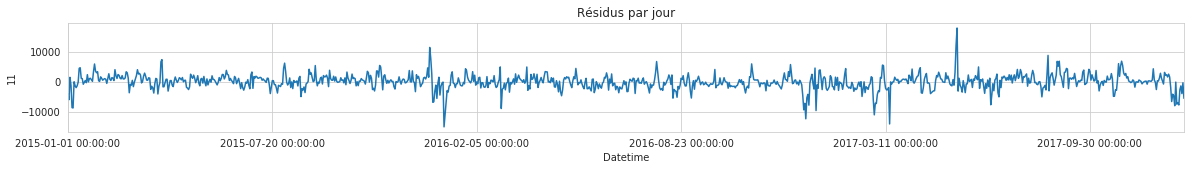

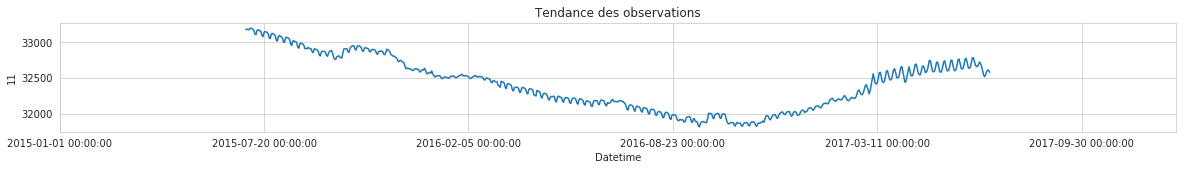

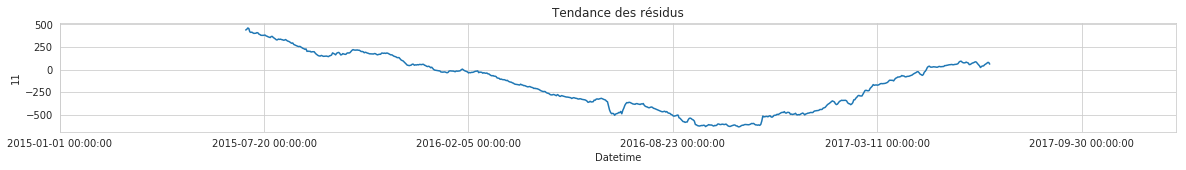

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.963

--------------------------------------------- Station 32 (2/10) ---------------------------------------------------


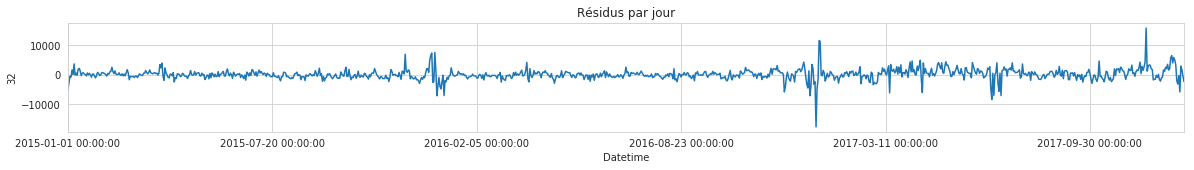

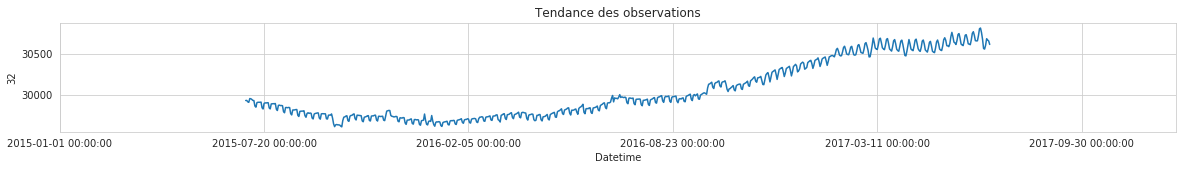

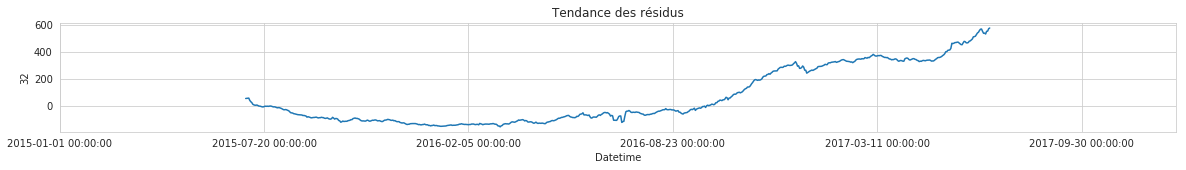

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.712

--------------------------------------------- Station 34 (3/10) ---------------------------------------------------


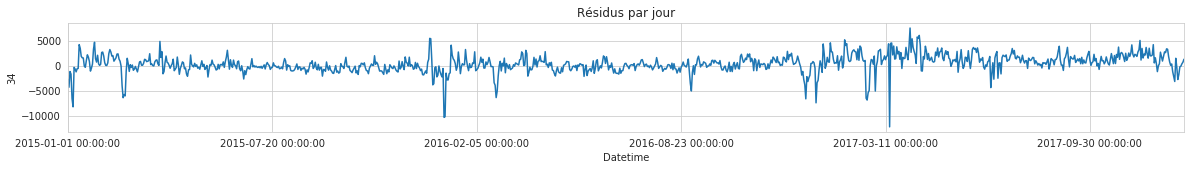

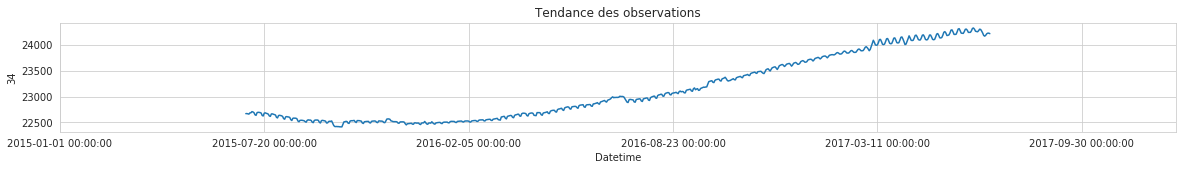

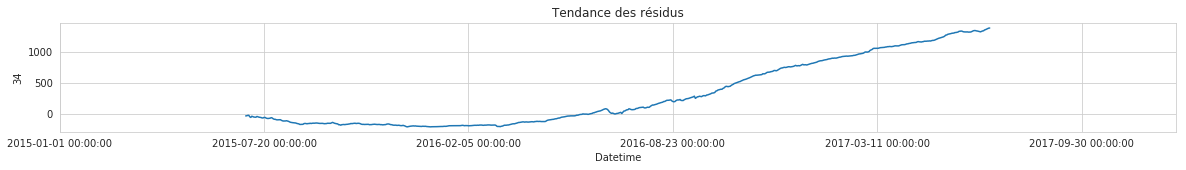

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.967

--------------------------------------------- Station 15 (4/10) ---------------------------------------------------


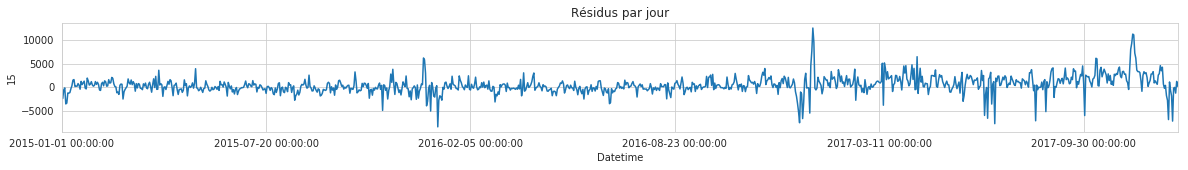

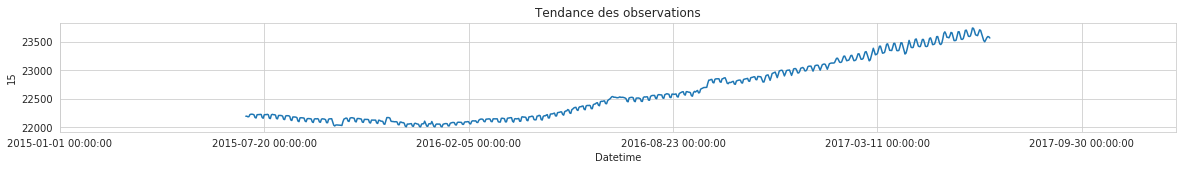

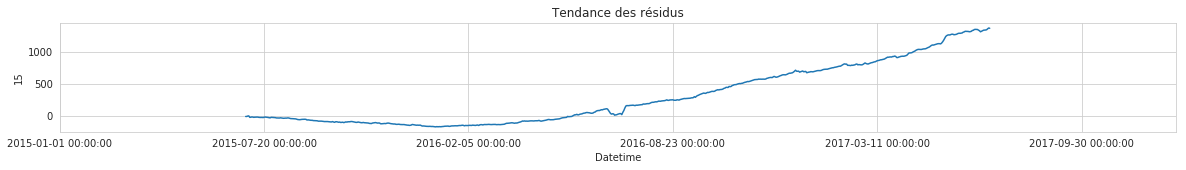

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.930

--------------------------------------------- Station 44 (5/10) ---------------------------------------------------


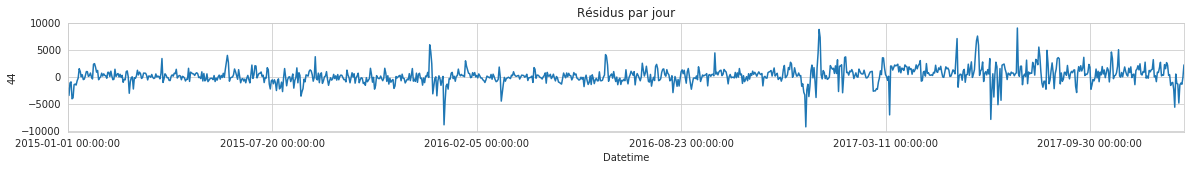

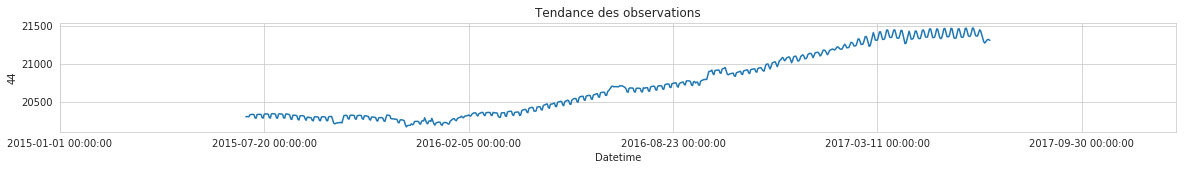

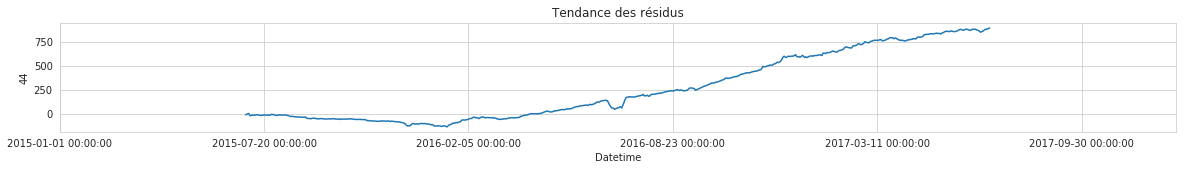

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.850

--------------------------------------------- Station 65 (6/10) ---------------------------------------------------


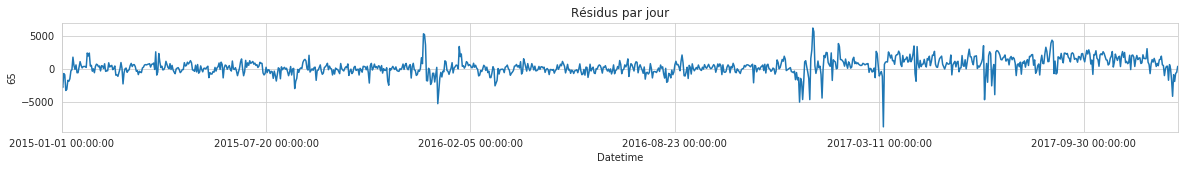

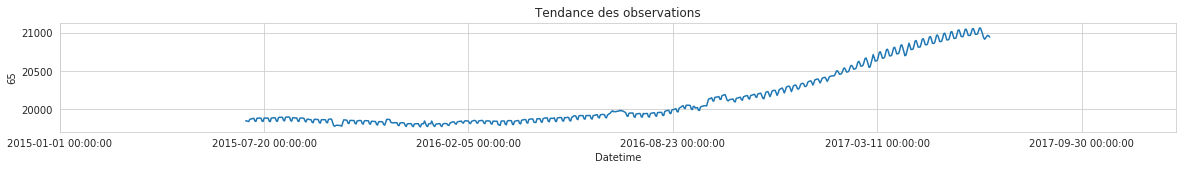

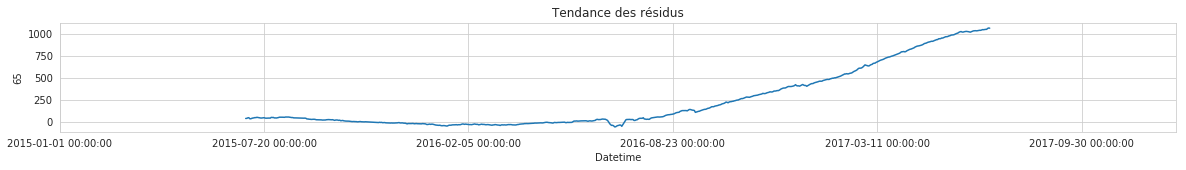

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.981

--------------------------------------------- Station 31 (7/10) ---------------------------------------------------


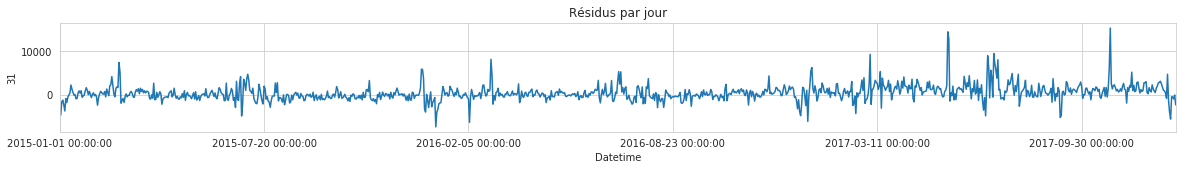

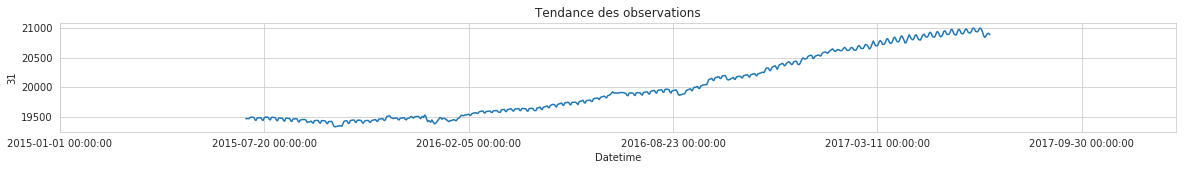

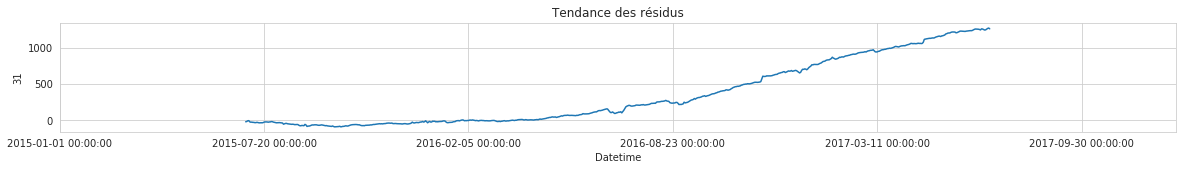

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.959

--------------------------------------------- Station 33 (8/10) ---------------------------------------------------


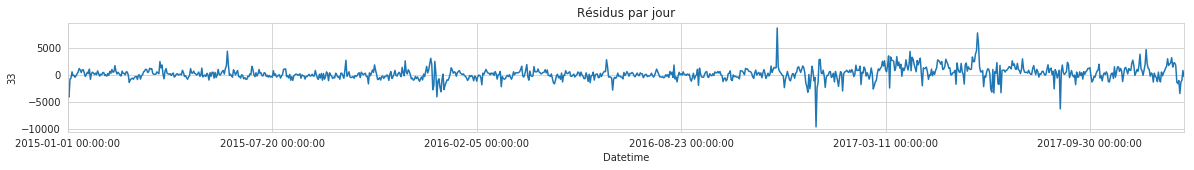

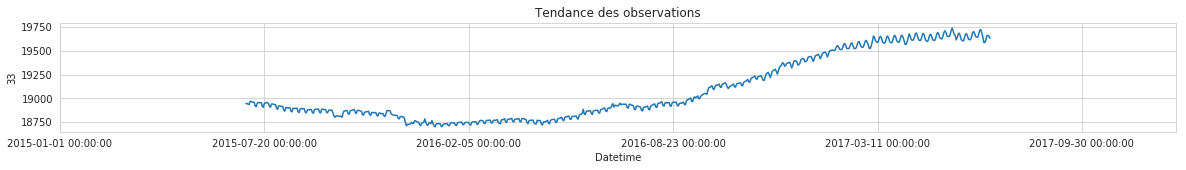

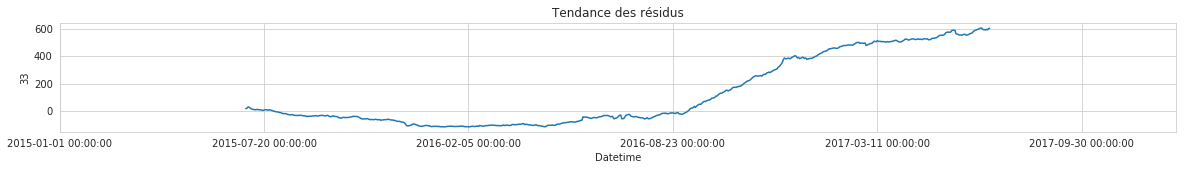

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.877

--------------------------------------------- Station 35 (9/10) ---------------------------------------------------


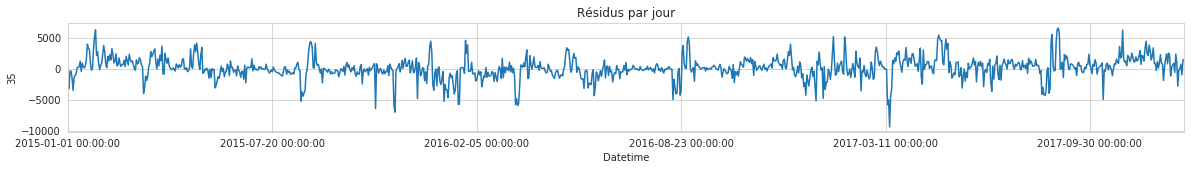

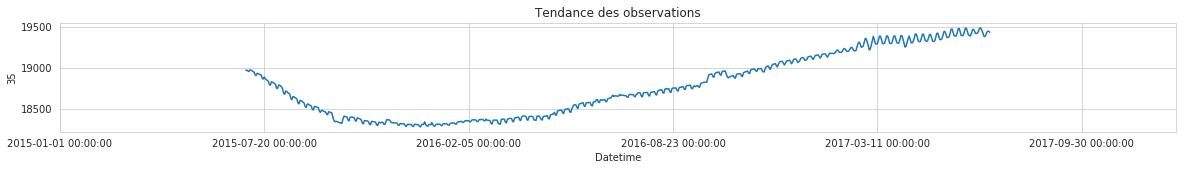

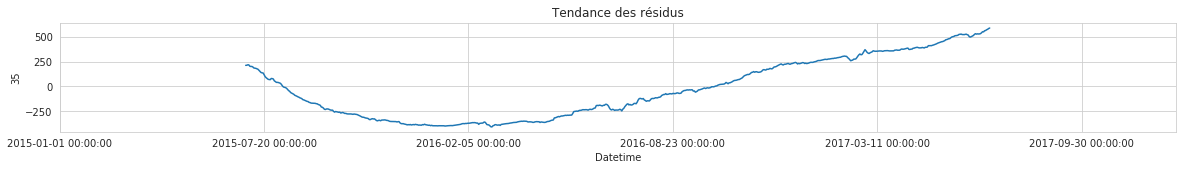

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.894

--------------------------------------------- Station 47 (10/10) ---------------------------------------------------


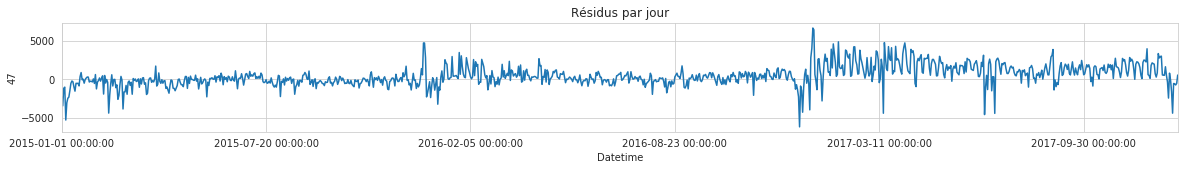

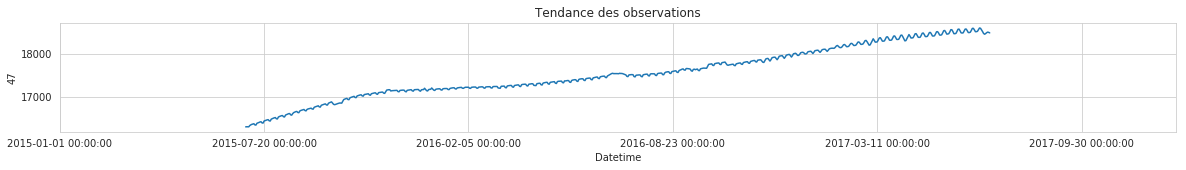

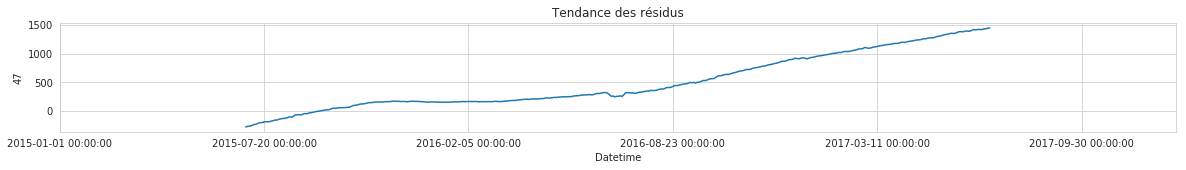

La corrélation entre la tendance des résidus de prévision et la tendance des observations est : 0.961



In [8]:
obs_ = obs.set_index('Datetime').loc[date_list].reset_index().copy()
pred_ = pred.set_index('Datetime').loc[date_list].reset_index().copy()

obs_['Datetime'] = [i[:10] + ' 00:00:00' for i in obs_['Datetime'].values]
obs_ = obs_.groupby('Datetime').sum().reset_index()
pred_['Datetime'] = [i[:10] + ' 00:00:00' for i in pred_['Datetime'].values]
pred_ = pred_.groupby('Datetime').sum().reset_index()

residus_ = (obs_.set_index('Datetime') - pred_.set_index('Datetime')).reset_index()

freq = 365
nts = 10

corr_list_day = []
for idx,ts in enumerate(obs.set_index('Datetime').columns.values[:nts]):
    print('--------------------------------------------- Station {} ({}/{}) ---------------------------------------------------'.format(ts,idx+1,len(obs.set_index('Datetime').columns.values[:nts])))
    fig,ax = plt.subplots(figsize=(20,2))
    residus_.set_index('Datetime')[ts].plot(ax=ax)
    plt.ylabel(ts)
    plt.title('Résidus par jour')
    plt.show()
    
    result_obs = seasonal_decompose(obs_.set_index('Datetime')[ts], model='additive', freq=freq)
    fig,ax = plt.subplots(figsize=(20,2))
    result_obs.trend.plot(ax=ax, legend = False)
    plt.ylabel(ts)
    plt.title('Tendance des observations')
    plt.show()
    
    result_residus = seasonal_decompose(residus_.set_index('Datetime')[ts], model='additive', freq=freq)
    fig,ax = plt.subplots(figsize=(20,2))
    result_residus.trend.plot(ax=ax, legend = False)
    plt.ylabel(ts)
    plt.title('Tendance des résidus')
    plt.show()
    
    
    corr_trend_obs_pred = np.corrcoef(result_obs.trend.dropna().loc['2017':].values,
                                      result_residus.trend.dropna().loc['2017':].values)[0][1]
    print('La corrélation entre la tendance des résidus de prévision et la tendance des observations est : {:.3f}\n'.format(corr_trend_obs_pred))

    corr_list_day.append(corr_trend_obs_pred)


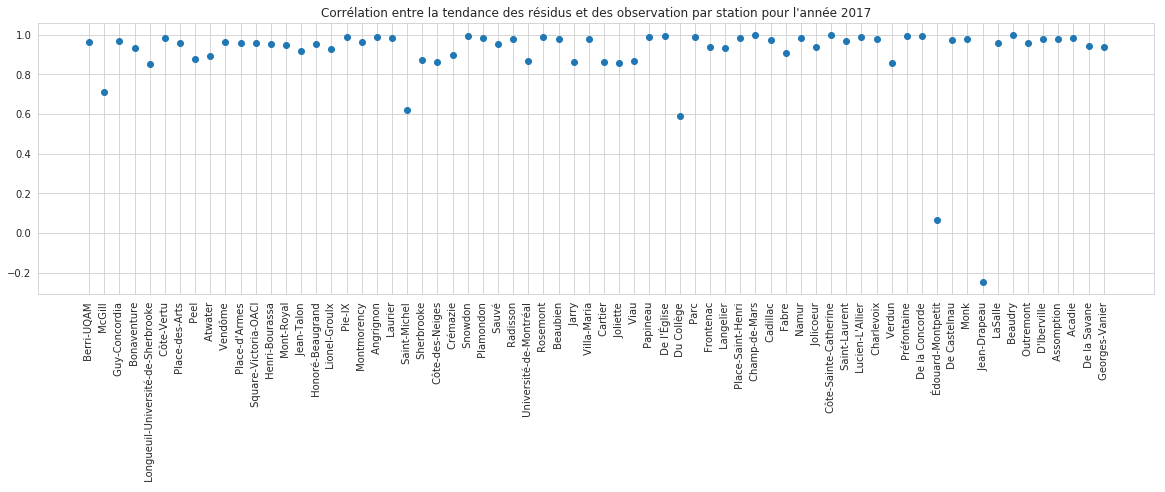

In [7]:
fig,ax = plt.subplots(figsize = (20,5))
plt.plot(corr_list_day, 'o')
plt.xticks(np.arange(len(corr_list_day)), [i[7:] for i in name_list], rotation=90)
plt.title("Corrélation entre la tendance des résidus et des observation par station pour l'année 2017")
plt.show()

<a id='link3'></a>
# Agrégation de la prévision par mois, calcul des résidus et affichage (heatmap)

L'erreur peut provenir de différents facteurs. Le modèle fait plus d'erreur en test (2017) qu'en train (2015 et 2016).  

La heatmap affiche des valeurs rouges (résidu positif: prévisions inférieures aux observations) lorsque le facteur du nombre de passager agrégé à l'année (2015,2016)->2017, est supérieur à 1  et en bleu (résidu négatif) lorsqu'il est inférieur à 1. 

Il semble donc que la tendance soit un facteur d'erreur pour certaines stations.

In [8]:
from numpy import ma
from matplotlib import cbook
from matplotlib.colors import Normalize

class MidPointNorm(Normalize):    
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")       
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = ma.getmask(result)
                result = ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint            
            resdat[resdat>0] /= abs(vmax - midpoint)            
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = ma.array(resdat, mask=result.mask, copy=False)                

        if is_scalar:
            result = result[0]            
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if cbook.iterable(value):
            val = ma.asarray(value)
            val = 2 * (val-0.5)  
            val[val>0]  *= abs(vmax - midpoint)
            val[val<0] *= abs(vmin - midpoint)
            val += midpoint
            return val
        else:
            val = 2 * (val - 0.5)
            if val < 0: 
                return  val*abs(vmin-midpoint) + midpoint
            else:
                return  val*abs(vmax-midpoint) + midpoint

In [49]:
pred = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/mt_rf_uni_inverted_eventsALLreduce_OPTIMALL/2015-01-01_2017-12-31.csv')
obs = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv')
pred_ = pred.copy()
pred_['Datetime'] = [i[:7] for i in pred_['Datetime'] ]
pred_ = pred_.groupby('Datetime').sum().reset_index()
obs_ = obs.copy()
obs_['Datetime'] = [i[:7] for i in obs_['Datetime'] ]
obs_ = obs_aggperday.groupby('Datetime').sum().reset_index()
date_list = obs_.set_index('Datetime')[[]].join(pred_.set_index('Datetime')[[]]).index.values

## Heatmap des résidus des prévisions agrégées par mois - par mois  et par station, normalisés par station

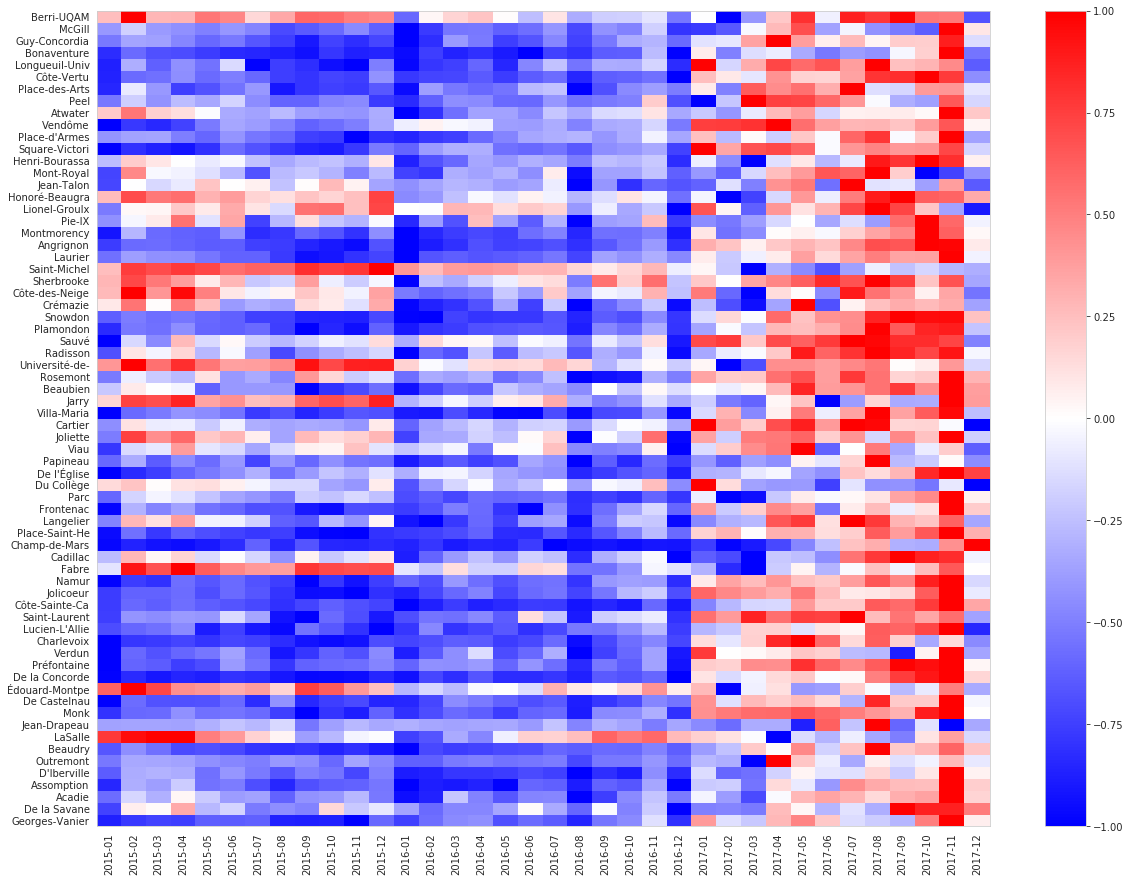

In [94]:
res = (obs_.set_index('Datetime').loc[date_list] - pred_.set_index('Datetime').loc[date_list] )
res_ = res.copy()[res.columns[::-1]]
res_ = (((res_ - res_.min()) / (res_.max() - res_.min())) * 2 - 1).T

norm = MidPointNorm(midpoint=0)


fig,ax = plt.subplots(figsize = (20, 15))
plt.pcolor(res_,cmap='bwr',norm=norm)
plt.yticks(np.arange(0.5, len(res_.index), 1), [dict_id_name[int(i)][8:22] for i in res_.index])
plt.xticks(np.arange(0.5, len(res_.columns), 1), res_.columns, rotation=90)
plt.colorbar()
plt.show()

## Heatmap des résidus des prévisions agrégées par mois - par mois  et par station

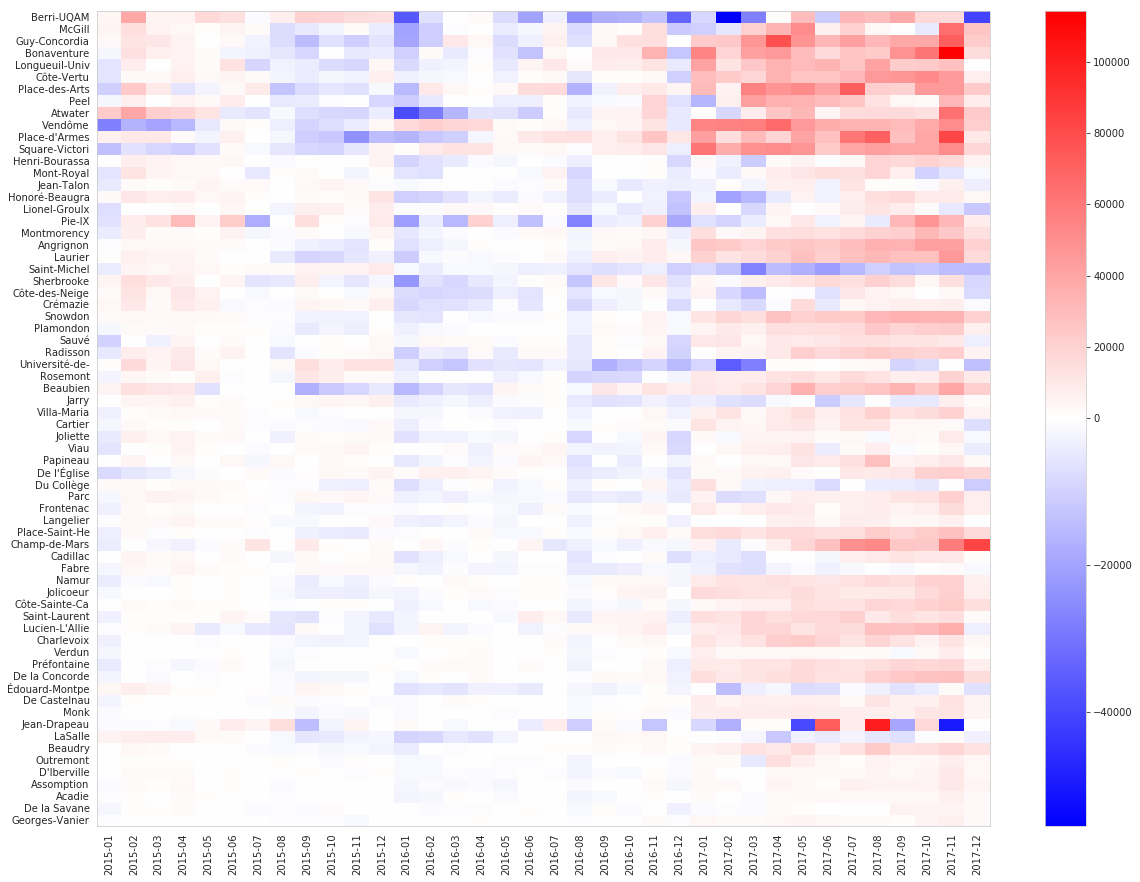

In [95]:
res = (obs_.set_index('Datetime').loc[date_list] - pred_.set_index('Datetime').loc[date_list] )
res_ = res.copy()[res.columns[::-1]].T

norm = MidPointNorm(midpoint=0)


fig,ax = plt.subplots(figsize = (20, 15))
plt.pcolor(res_,cmap='bwr',norm=norm)
plt.yticks(np.arange(0.5, len(res_.index), 1), [dict_id_name[int(i)][8:22] for i in res_.index])
plt.xticks(np.arange(0.5, len(res_.columns), 1), res_.columns, rotation=90)
plt.colorbar()
plt.show()

# Heatmap résidus par quart d'heure (résidu positif -> rouge, négatif -> bleu)
Cela ne permet pas de voir quoi que ce soit

In [26]:
pred = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/mt_rf_uni_inverted_eventsALLreduce_OPTIMALL/2015-01-01_2017-12-31.csv')
obs = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv')
date_list = obs.set_index('Datetime')[[]].join(pred.set_index('Datetime')[[]]).index.values

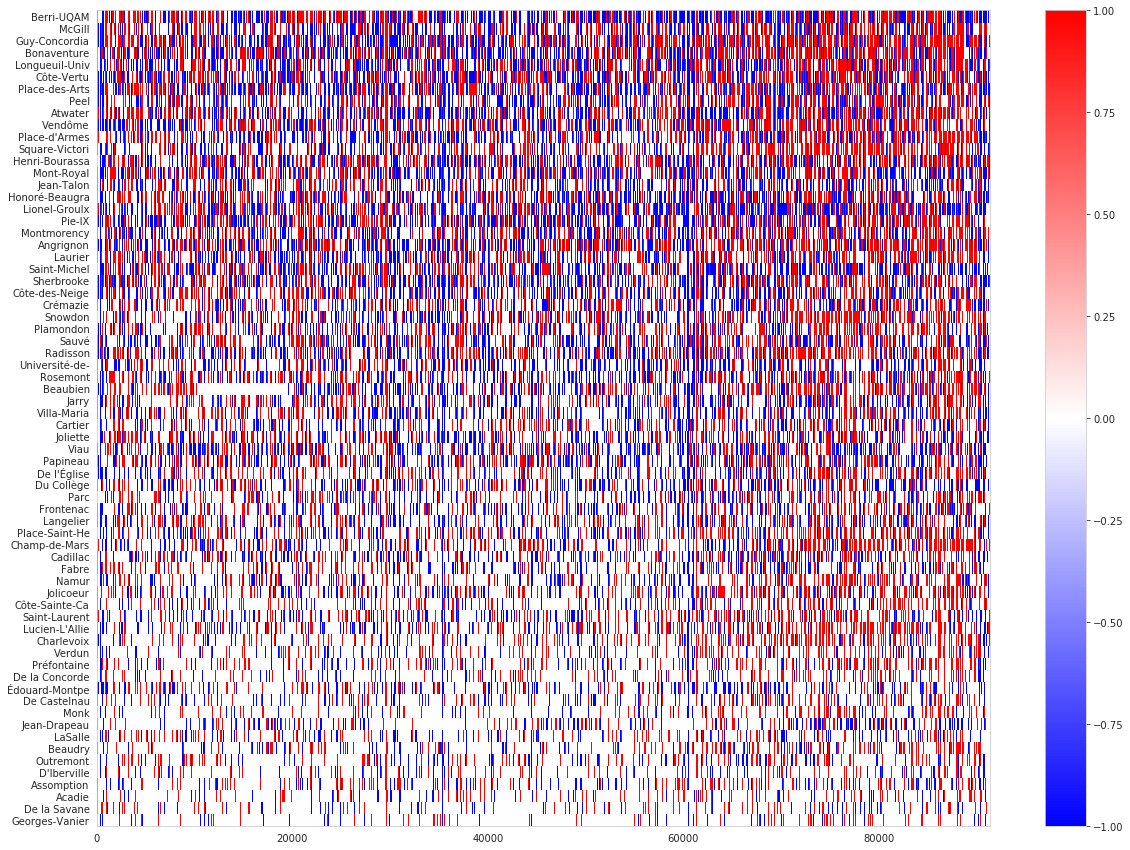

In [41]:
res = (obs.set_index('Datetime').loc[date_list] - pred.set_index('Datetime').loc[date_list] )
res[(res<=10) & (res>=-10)]=0
res[res>10]=1
res[res<-10]=-1

res_ = res.copy()[res.columns[::-1]].T

#norm = MidPointNorm(midpoint=0)


fig,ax = plt.subplots(figsize = (20, 15))
#plt.pcolor(res_,cmap='bwr',norm=norm)
plt.pcolor(res_,cmap='bwr')
plt.yticks(np.arange(0.5, len(res_.index), 1), [dict_id_name[int(i)][8:22] for i in res_.index])
#plt.xticks(np.arange(0.5, len(res_.columns), 1), res_.columns, rotation=90)
plt.colorbar()
plt.show()

# Facteur de changement entre les années

In [14]:
pred = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/mt_rf_uni_inverted_eventsALLreduce_OPTIMALL/2015-01-01_2017-12-31.csv')
obs = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv')
date_list = obs.set_index('Datetime')[[]].join(pred.set_index('Datetime')[[]]).index.values

In [15]:
obs_ = obs.copy()
obs_['Datetime'] = [i[:4] for i in obs_['Datetime'] ]
obs_ = obs_.groupby('Datetime').sum().T

In [16]:
obs_['Facteur 2015->2016'] = obs_['2016']/obs_['2015']
obs_['Facteur 2016->2017'] = obs_['2017']/obs_['2016']
obs_['Facteur (2015+2016)/2->2017'] = obs_['2017']/((obs_['2015']+obs_['2016'])/2)

In [17]:
obs_['station'] = obs_.index.values
obs_ = obs_.reset_index(drop=True)
obs_['station'] = [dict_id_name[int(i)] for i in obs_['station']]
obs_.set_index('station')

Datetime                                          2015        2016  \
station                                                              
Station Berri-UQAM                          12110859.0  11758679.0   
Station McGill                              10925249.0  10954790.0   
Station Guy-Concordia                        8274833.0   8404254.0   
Station Bonaventure                          8102216.0   8230720.0   
Station Longueuil-Université-de-Sherbrooke   7409047.0   7564504.0   
Station Côte-Vertu                           7245137.0   7301083.0   
Station Place-des-Arts                       7105687.0   7273743.0   
Station Peel                                 6914640.0   6920906.0   
Station Atwater                              6924113.0   6821566.0   
Station Vendôme                              5953371.0   6412049.0   
Station Place-d'Armes                        5896131.0   6208263.0   
Station Square-Victoria-OACI                 5140698.0   5506310.0   
Station Henri-Bourassa                       5211737.0   5169187.0   
Station Mont-Royal                           5027446.0   5014956.0   
Station Jean-Talon                           5097240.0   4862807.0   
Station Honoré-Beaugrand                     5012353.0   4877298.0   
Station Lionel-Groulx                        4900649.0   4890819.0   
Station Pie-IX                               4857658.0   4688637.0   
Station Montmorency                          4648146.0   4693077.0   
Station Angrignon                            4402525.0   4455161.0   
Station Laurier                              4091541.0   4244414.0   
Station Saint-Michel                         4371981.0   4252253.0   
Station Sherbrooke                           4184634.0   4196667.0   
Station Côte-des-Neiges                      4134134.0   4068171.0   
Station Crémazie                             3903995.0   3841766.0   
Station Snowdon                              3602648.0   3619967.0   
Station Plamondon                            3624141.0   3664859.0   
Station Sauvé                                3569727.0   3628390.0   
Station Radisson                             3582453.0   3562825.0   
Station Université-de-Montréal               3288346.0   3078850.0   
...                                                ...         ...   
Station De l'Église                          2619096.0   2666188.0   
Station Du Collège                           2671099.0   2658677.0   
Station Parc                                 2593162.0   2500542.0   
Station Frontenac                            2448668.0   2497721.0   
Station Langelier                            2479776.0   2459212.0   
Station Place-Saint-Henri                    2288298.0   2369913.0   
Station Champ-de-Mars                        2322108.0   2250630.0   
Station Cadillac                             2267640.0   2240176.0   
Station Fabre                                2273487.0   2202330.0   
Station Namur                                2093485.0   2170108.0   
Station Jolicoeur                            1970428.0   2061628.0   
Station Côte-Sainte-Catherine                1945292.0   1917651.0   
Station Saint-Laurent                        1804612.0   1869730.0   
Station Lucien-L'Allier                      1764806.0   1832567.0   
Station Charlevoix                           1736747.0   1813658.0   
Station Verdun                               1689678.0   1725973.0   
Station Préfontaine                          1521167.0   1571352.0   
Station De la Concorde                       1392360.0   1453714.0   
Station Édouard-Montpetit                    1541184.0   1479419.0   
Station De Castelnau                         1416708.0   1446510.0   
Station Monk                                 1380132.0   1403302.0   
Station Jean-Drapeau                         1417985.0   1413880.0   
Station LaSalle                              1461953.0   1401887.0   
Station Beaudry                              1298110.0   1329687.0   
Station Ou

In [25]:
obs_.set_index('station').loc[['Station Berri-UQAM', 'Station Saint-Michel',
                               'Station Université-de-Montréal', 'Station Jarry',
                               'Station Du Collège', 'Station Édouard-Montpetit', 'Station LaSalle']]

Datetime                              2015        2016        2017  \
station                                                              
Station Berri-UQAM              12110859.0  11758679.0  11832171.0   
Station Saint-Michel             4371981.0   4252253.0   4080510.0   
Station Université-de-Montréal   3288346.0   3078850.0   3046050.0   
Station Jarry                    3062105.0   2991203.0   2958064.0   
Station Du Collège               2671099.0   2658677.0   2614231.0   
Station Édouard-Montpetit        1541184.0   1479419.0   1440809.0   
Station LaSalle                  1461953.0   1401887.0   1363908.0   

Datetime                        Facteur 2015->2016  Facteur 2016->2017  \
station                                                                  
Station Berri-UQAM                        0.970920            1.006250   
Station Saint-Michel                      0.972615            0.959611   
Station Université-de-Montréal            0.936291            0.989347   
Station Jarry                             0.976845            0.988921   
Station Du Collège                        0.995349            0.983283   
Station Édouard-Montpetit                 0.959924            0.973902   
Station LaSalle                           0.958914            0.972909   

Datetime                        Facteur (2015+2016)/2->2017  
station                                                      
Station Berri-UQAM                                 0.991403  
Station Saint-Michel                               0.946289  
Station Université-de-Montréal                     0.956795  
Station Jarry                                      0.977338  
Station Du Collège                                 0.980991  
Station Édouard-Montpetit                          0.953988  
Station LaSalle                                    0.952503

# Affichage des valeurs absolues des résidus en fonction de la tendance

Cela ne permet pas de conclure quoi que ce soit

In [9]:
pred = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/mt_rf_uni_inverted_eventsALLreduce_OPTIMALL/2015-01-01_2017-12-31.csv')
obs = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv')
date_list = obs.set_index('Datetime')[[]].join(pred.set_index('Datetime')[[]]).index.values

FREQ=1.0*96


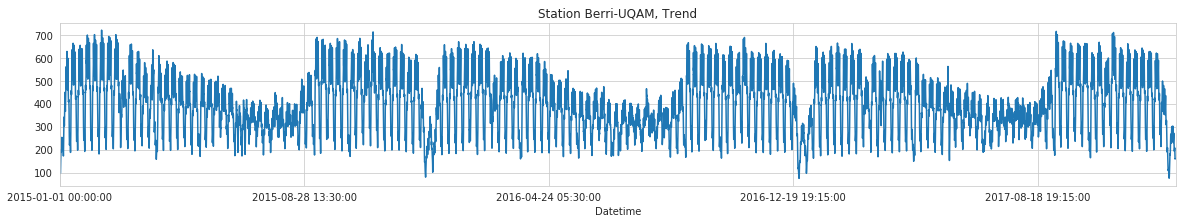

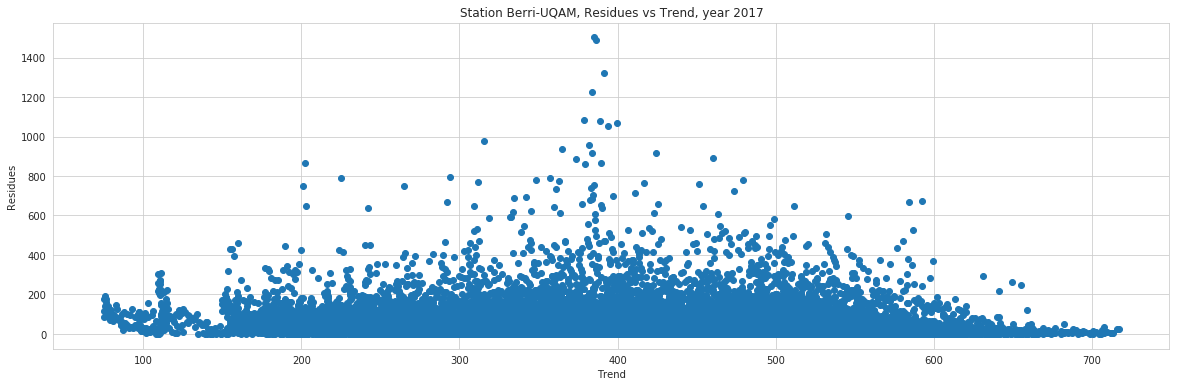

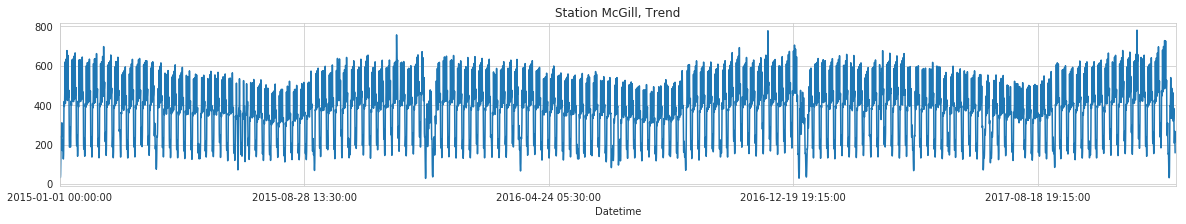

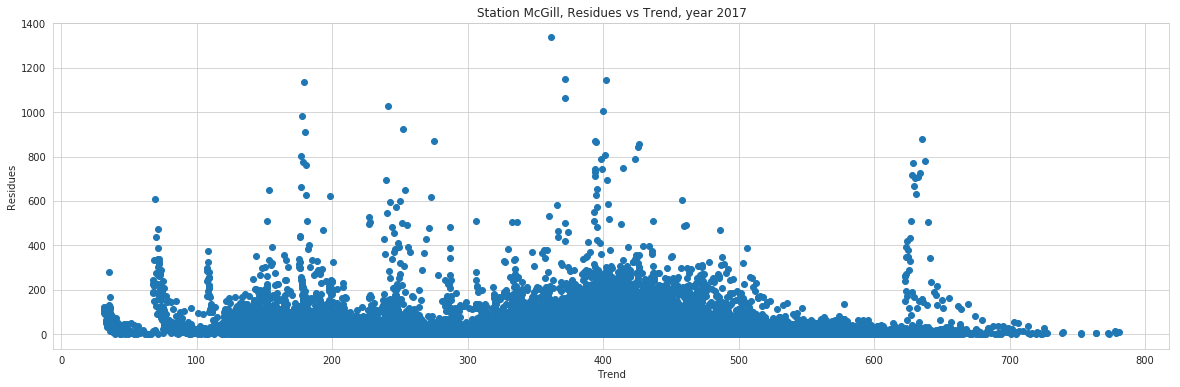

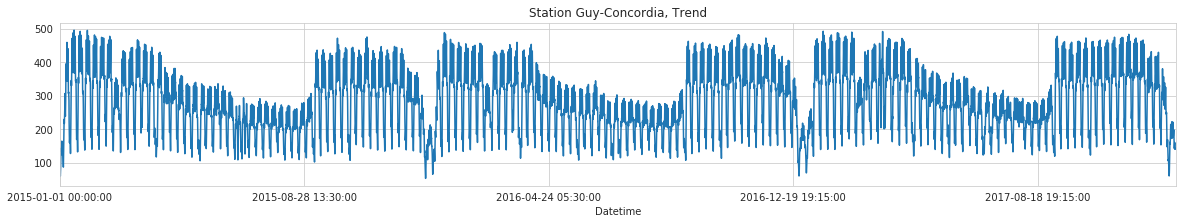

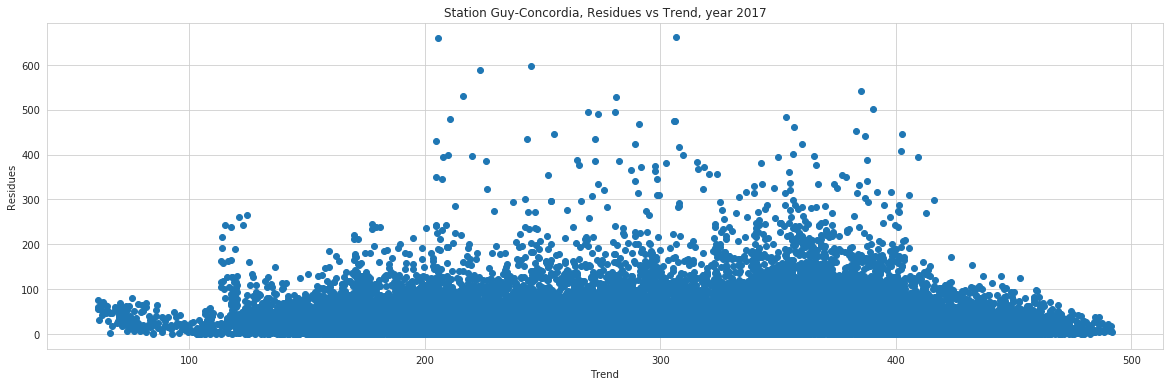

FREQ=7.0*96


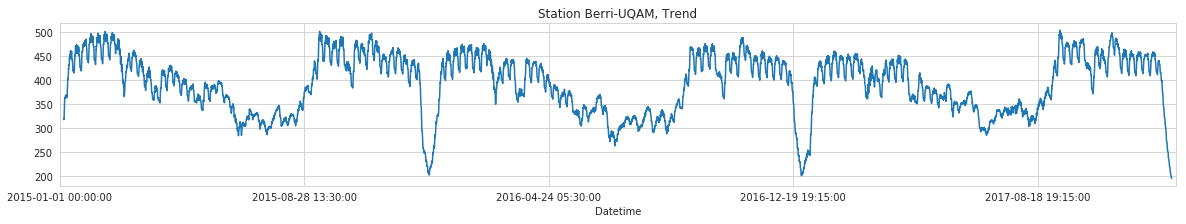

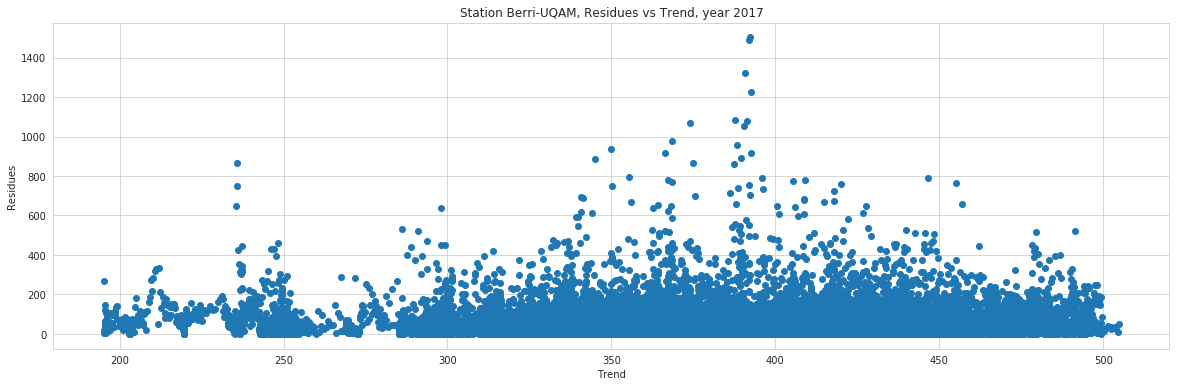

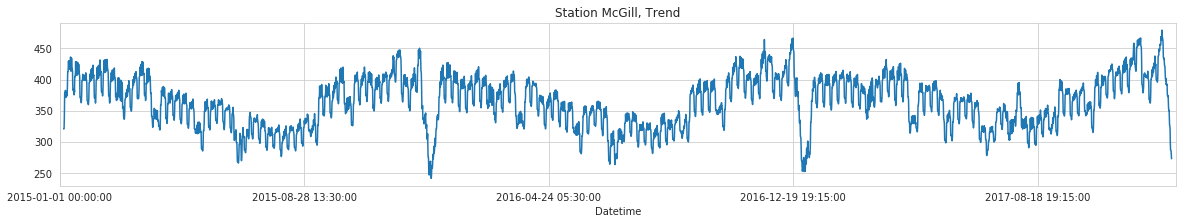

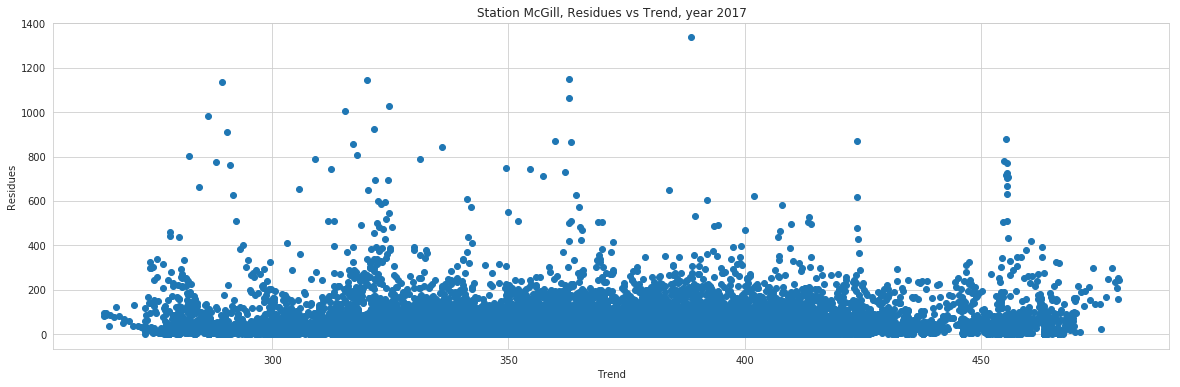

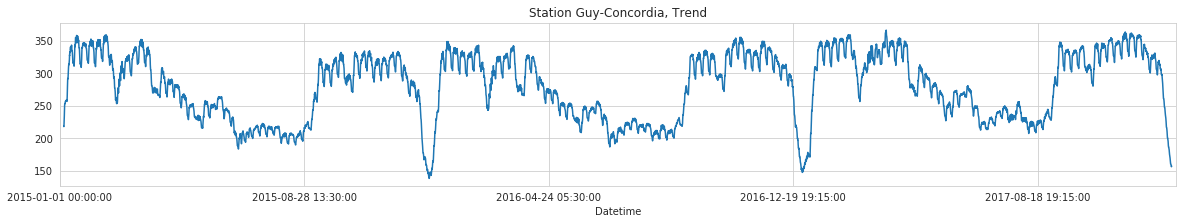

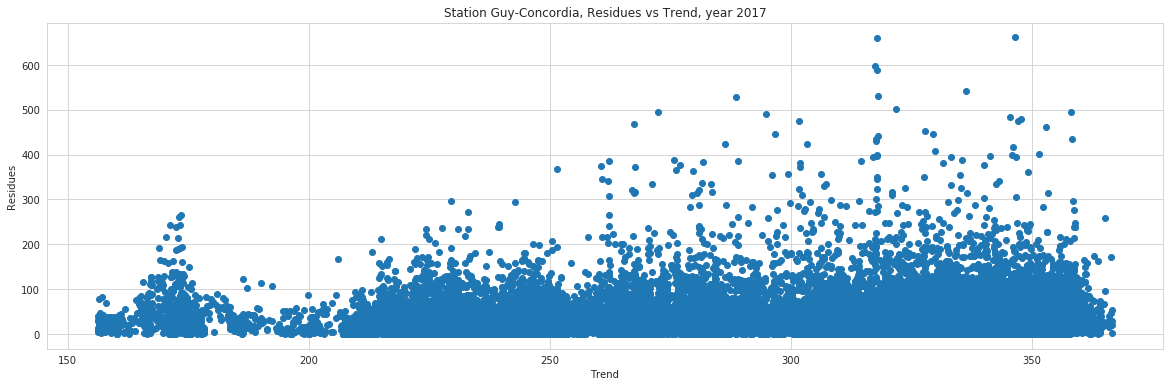

FREQ=30.0*96


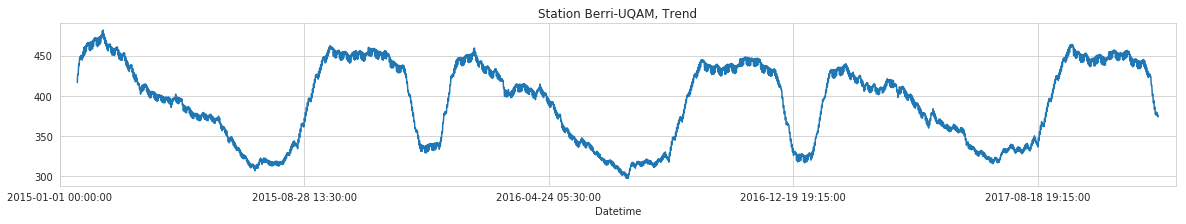

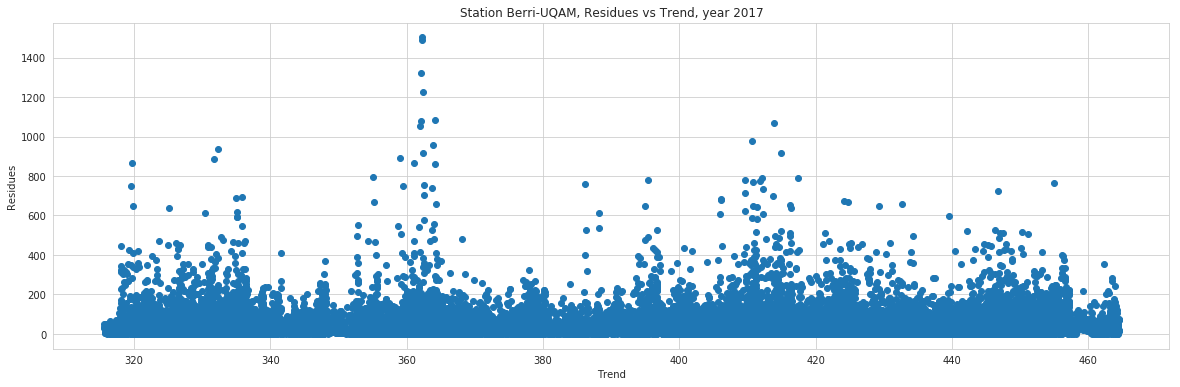

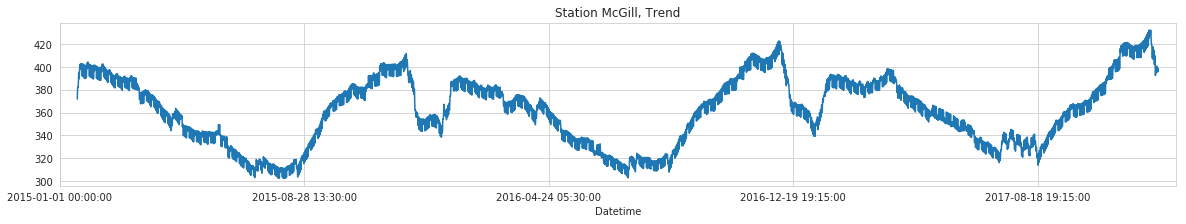

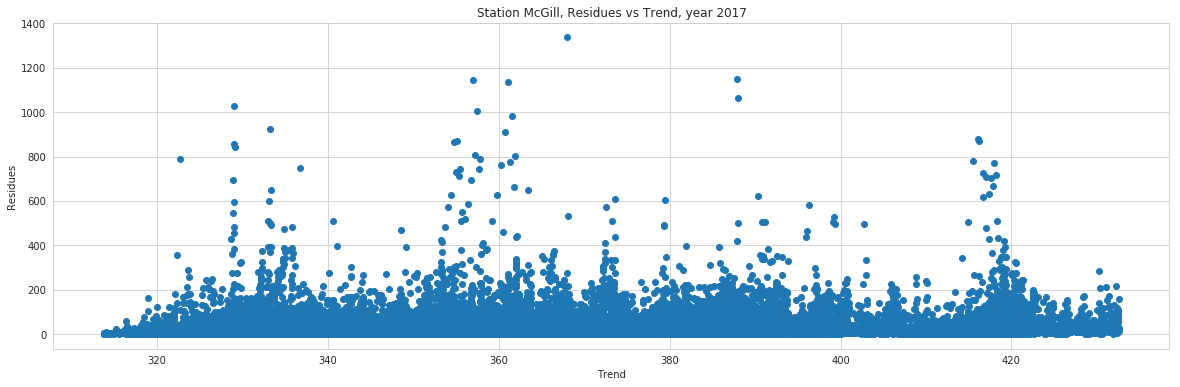

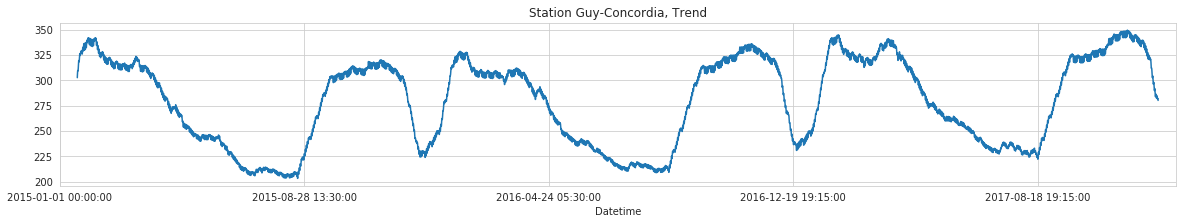

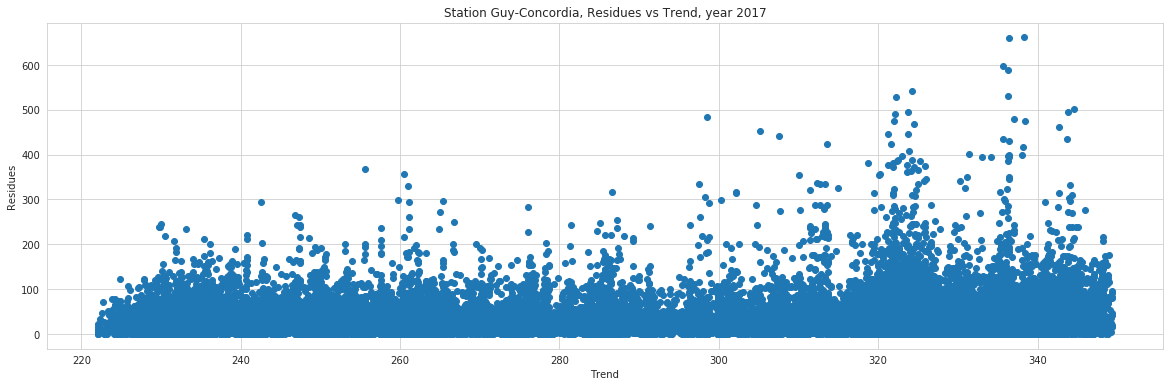

FREQ=365.0*96


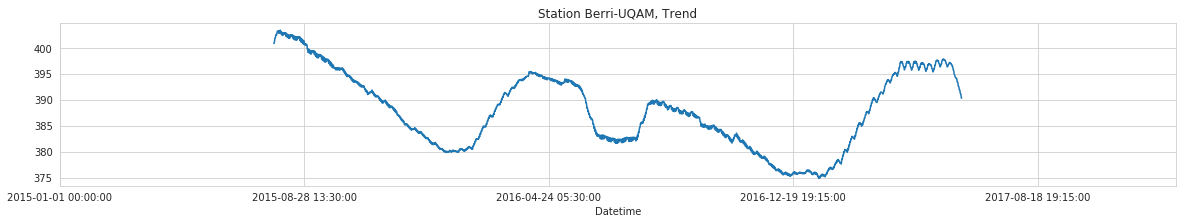

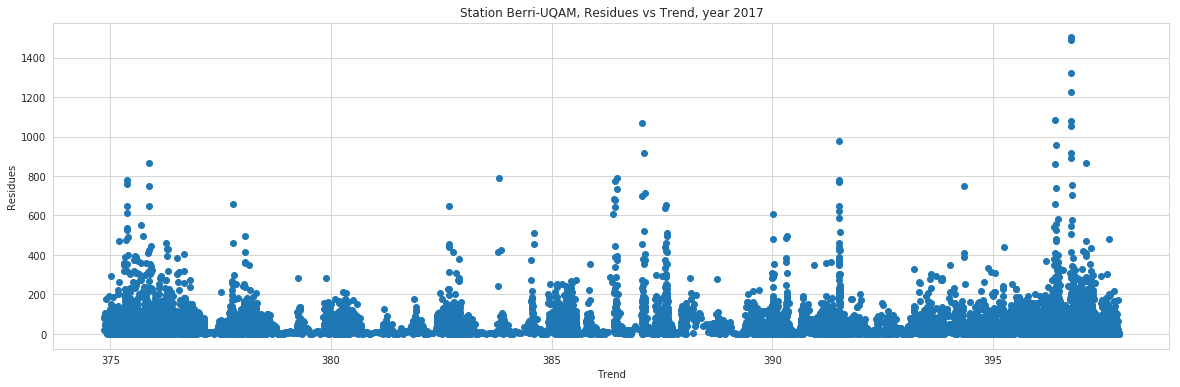

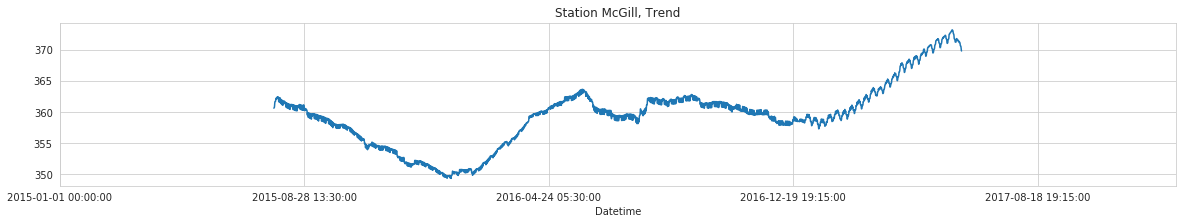

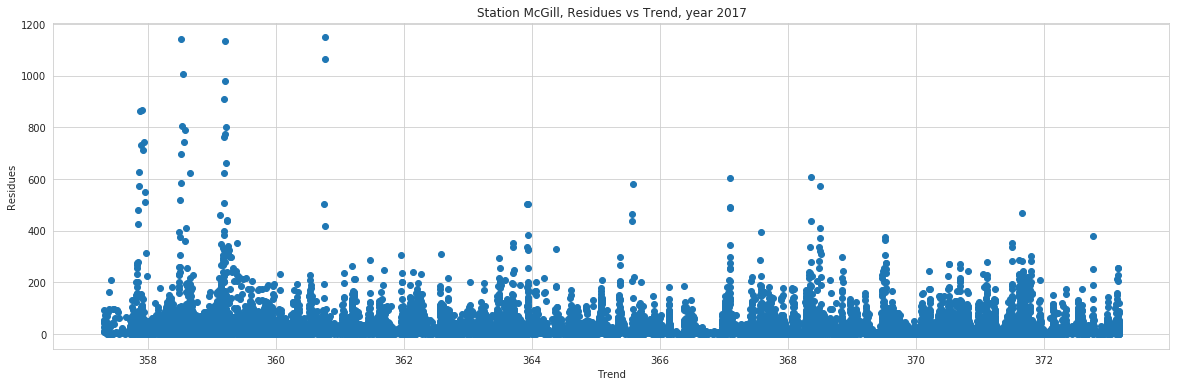

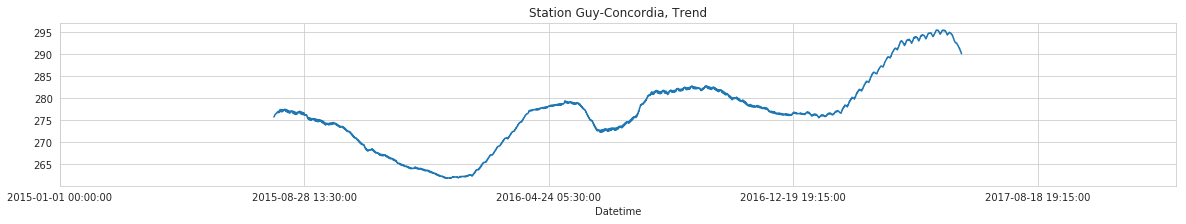

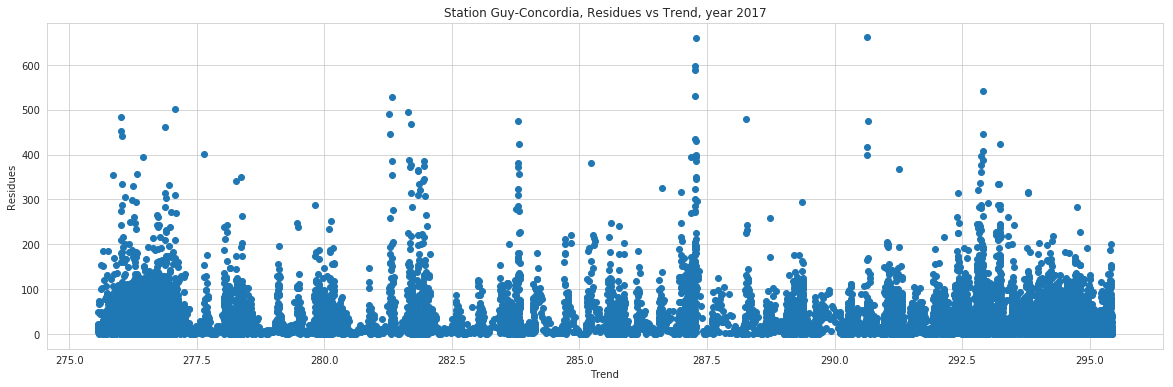

In [36]:
res = (obs.set_index('Datetime').loc[date_list] - pred.set_index('Datetime').loc[date_list] ).reset_index()

freqs = [1*96, 7*96, 30*96, 365*96]

for freq in freqs:
    print('FREQ={}*96'.format(freq/96))
    nts = 3 # number of time series
    start = '2017'
    end = '2018'
    for ts in obs.set_index('Datetime').columns.values[:nts]:
        result_obs = seasonal_decompose(obs.set_index('Datetime')[ts], model='additive', freq=freq)
        date_list_trend = result_obs.trend.dropna().loc[start:end].index.values
        trend_list = result_obs.trend.dropna().loc[date_list_trend].values.tolist()
        residus_list = residus.set_index('Datetime').loc[date_list_trend][ts].values.tolist()
        
        fig, ax= plt.subplots(figsize=(20,3))
        result_obs.trend.plot(ax=ax,legend=False)
        plt.title('{}, Trend'.format(dict_id_name[int(ts)]))
        plt.show()
        
        
        fig, ax= plt.subplots(figsize=(20,6))
        plt.plot(trend_list,np.abs(np.array(residus_list)),'o')
        plt.xlabel('Trend')
        plt.ylabel('Residues')
        plt.title('{}, Residues vs Trend, year 2017'.format(dict_id_name[int(ts)]))
        plt.show()

# [Trend 2017 - ( Trend (2015) +  Trend (2016))/2] VS Residues

On peut voir une très légère correlation entre la différence de tendance entre 2015,2016 et 2017 et les résidus de 2017.
Plus la différence de tendance est élevé plus les résidus sont élevés (station guy concordia).

Cela reste hypothétique

In [37]:
pred = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/mt_rf_uni_inverted_eventsALLreduce_OPTIMALL/2015-01-01_2017-12-31.csv')
obs = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv')
date_list = obs.set_index('Datetime')[[]].join(pred.set_index('Datetime')[[]]).index.values

Station Berri-UQAM


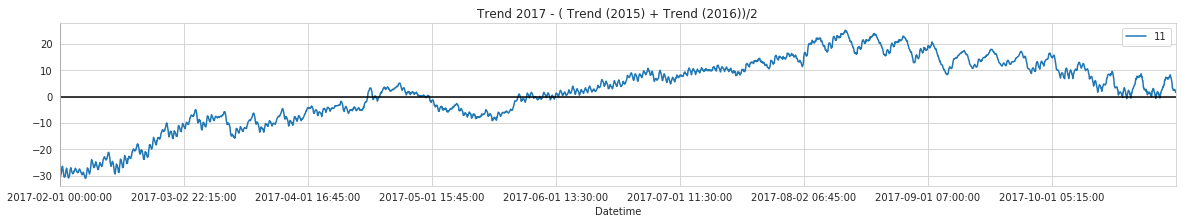

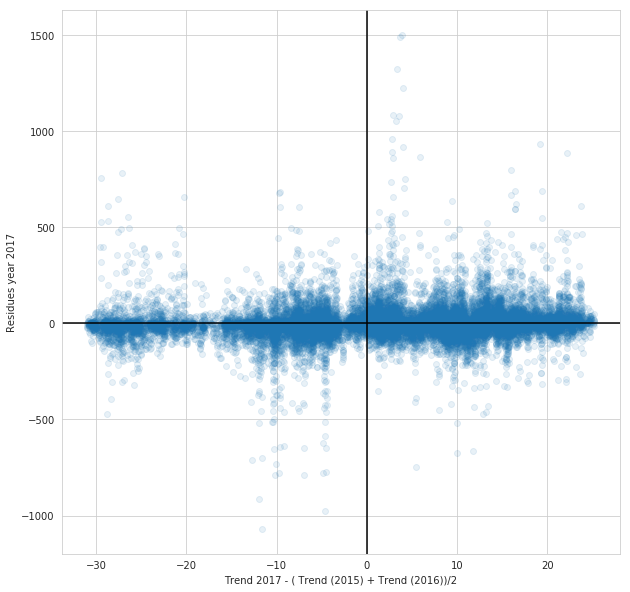

Station McGill


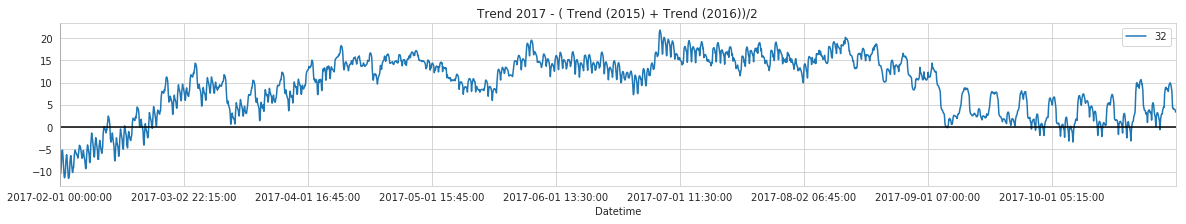

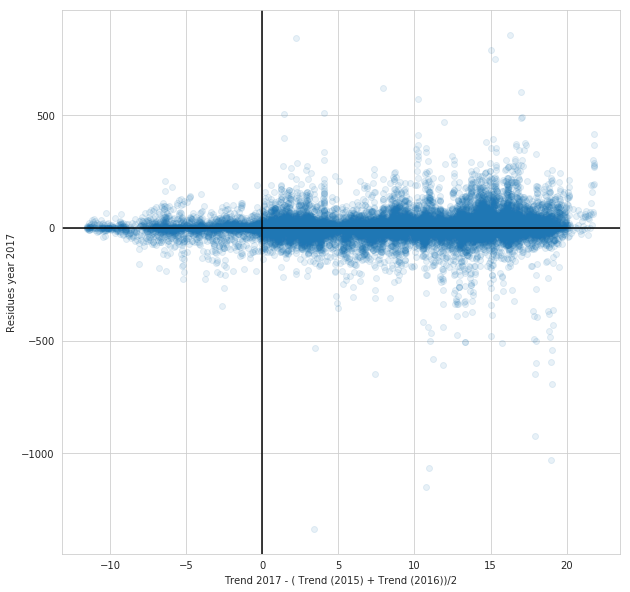

Station Guy-Concordia


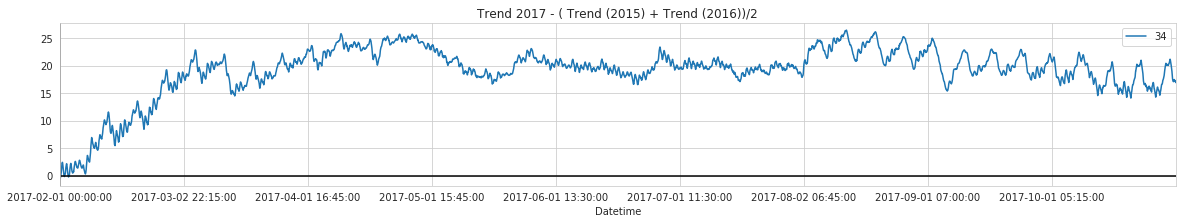

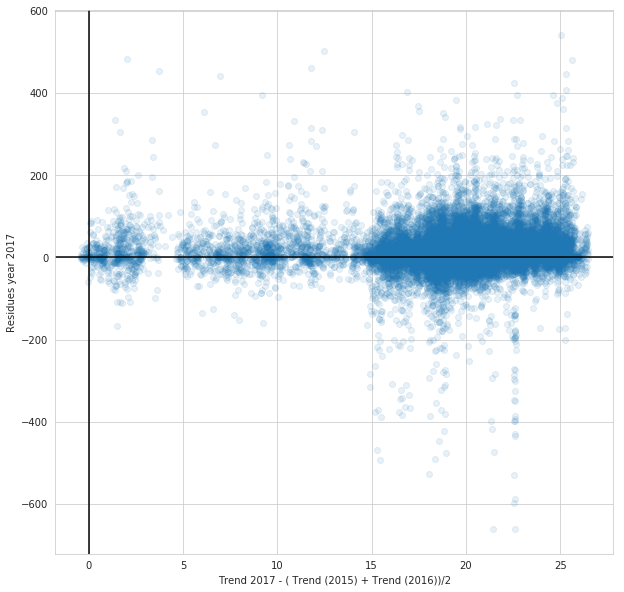

Station Bonaventure


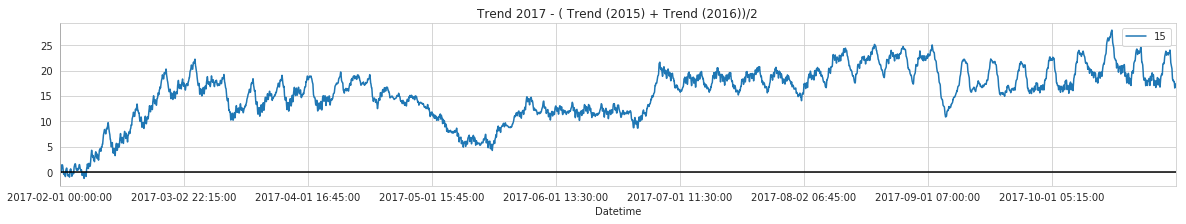

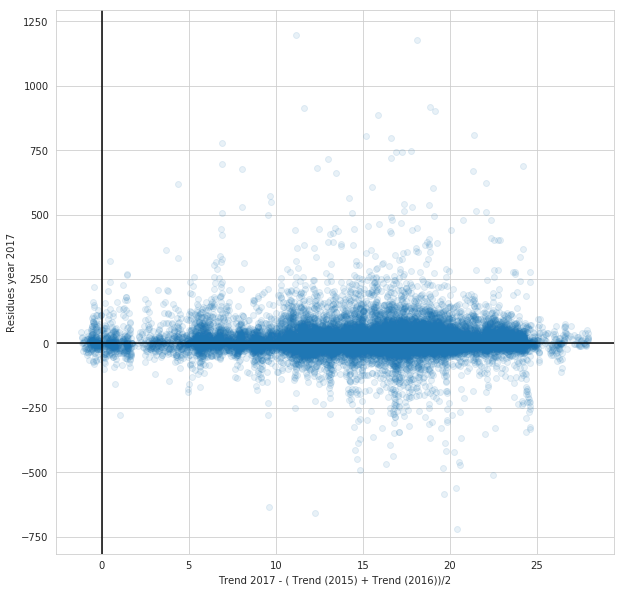

Station Longueuil-Université-de-Sherbrooke


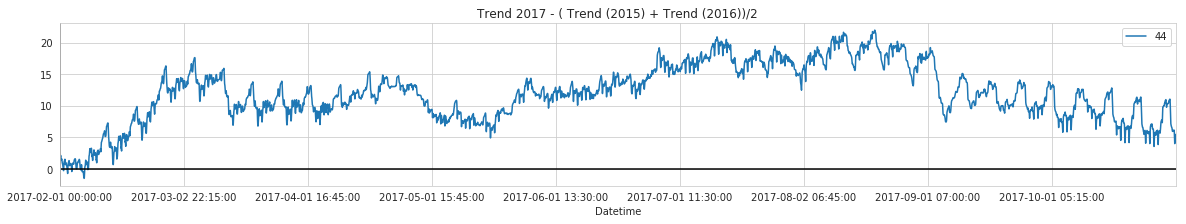

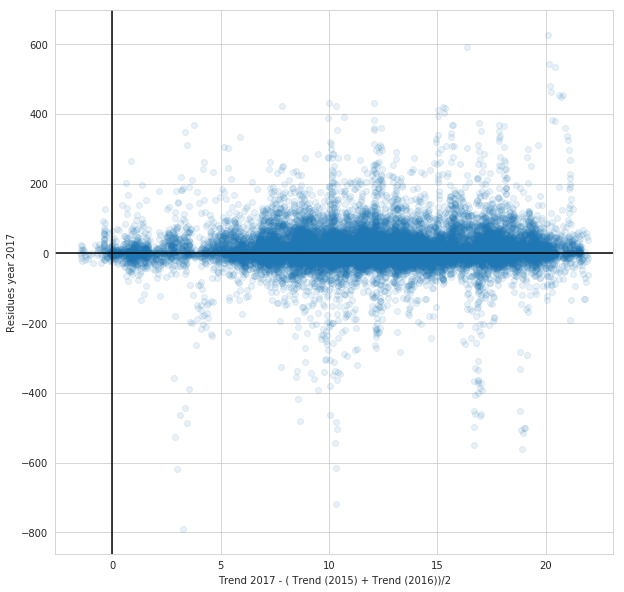

Station Côte-Vertu


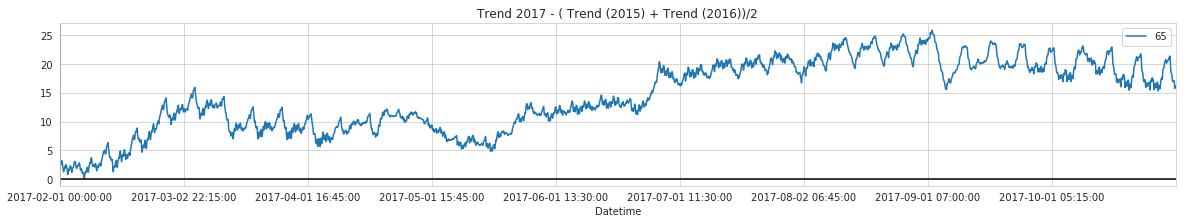

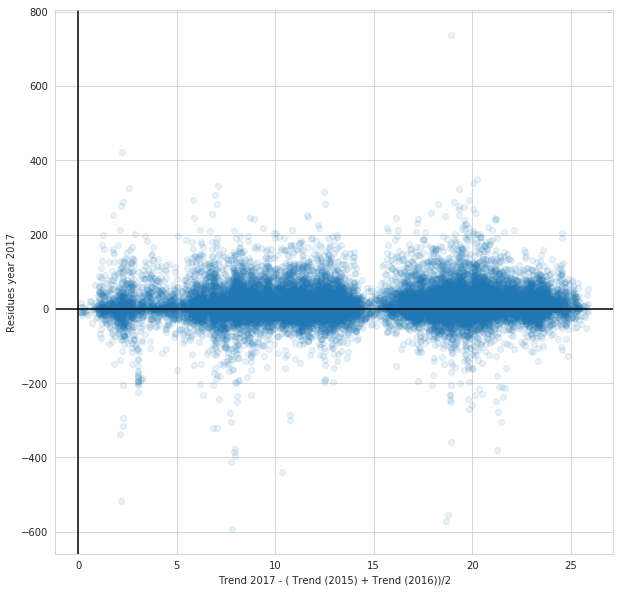

Station Place-des-Arts


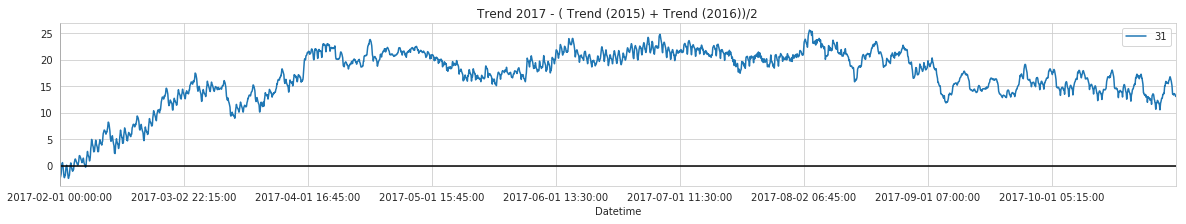

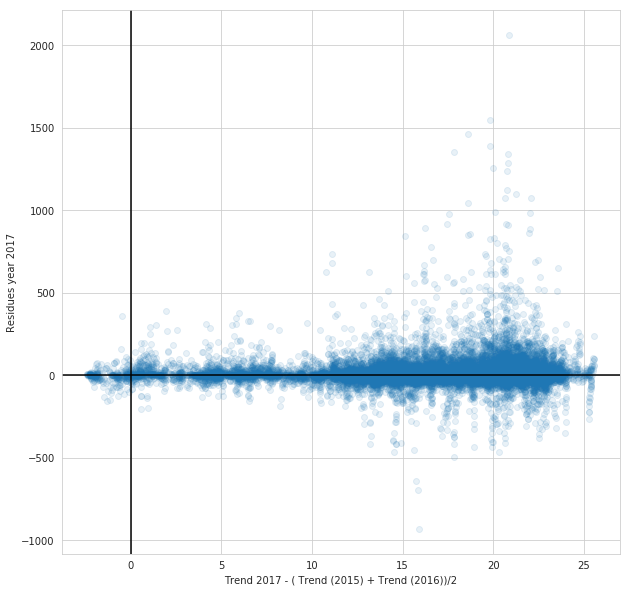

Station Peel


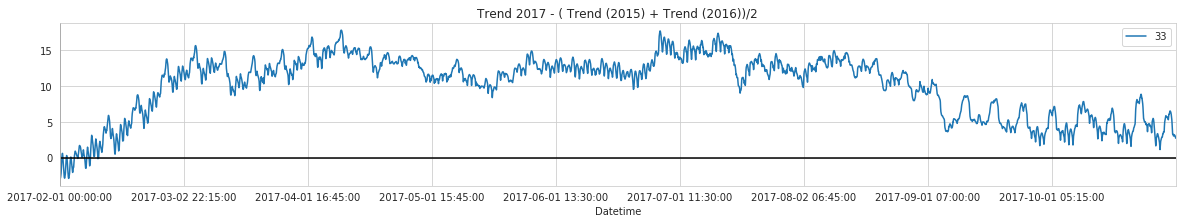

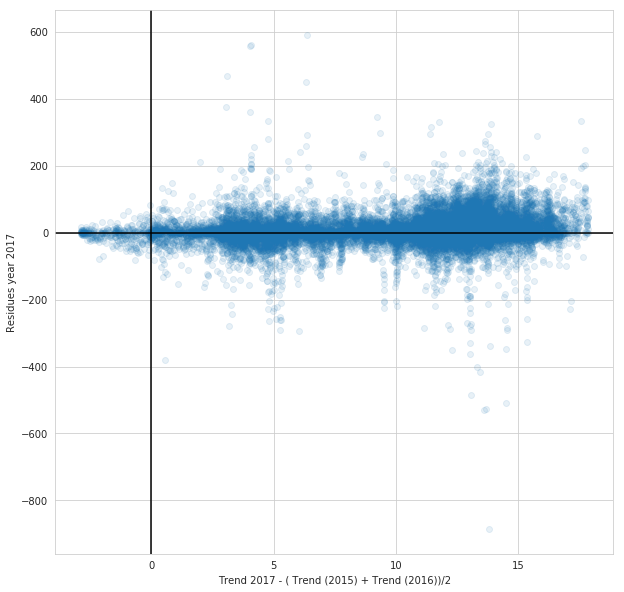

Station Atwater


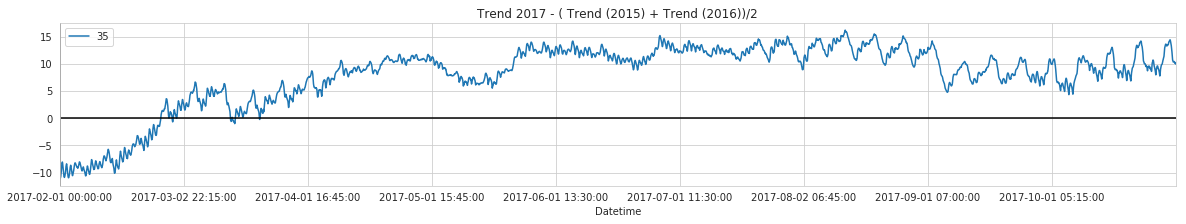

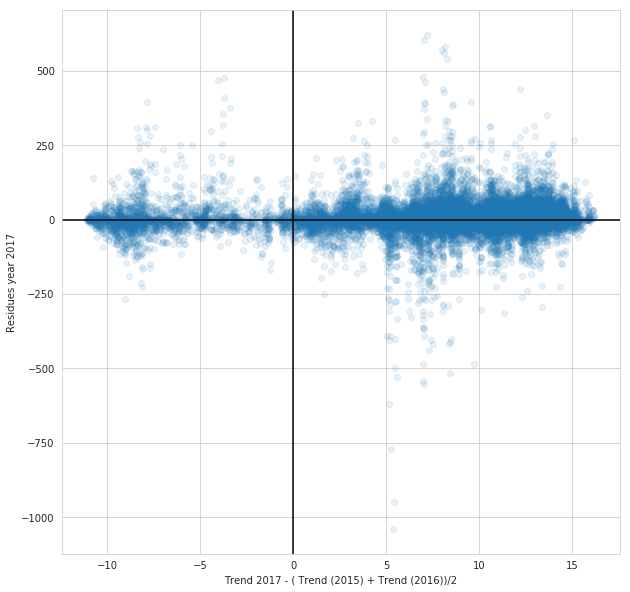

Station Vendôme


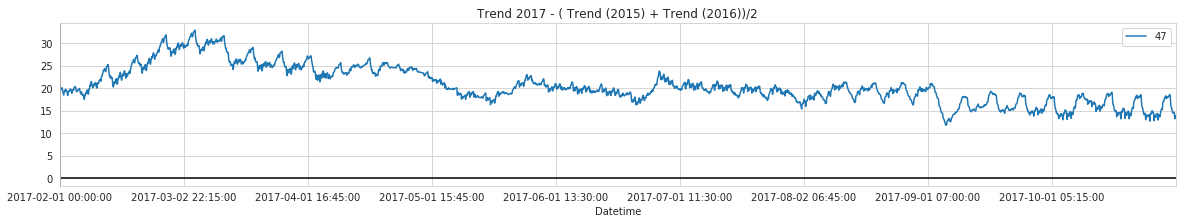

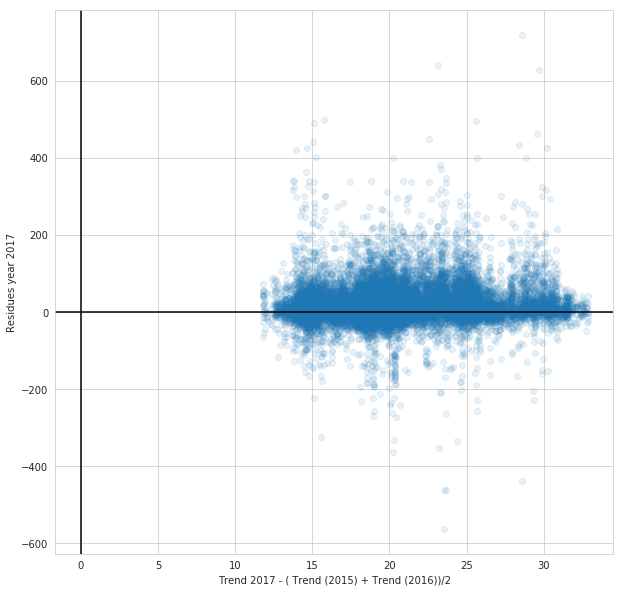

In [121]:
res = (obs.set_index('Datetime').loc[date_list] - pred.set_index('Datetime').loc[date_list] ).reset_index()

nts = 10 # number of time series
start = '2017'
end = '2018'
freq = 60*96

for ts in obs.set_index('Datetime').columns.values[:nts]:
    print('{}'.format(dict_id_name[int(ts)]))
    result_obs = seasonal_decompose(obs.set_index('Datetime')[ts], model='additive', freq=freq)
    
    trend2015 = result_obs.trend.dropna().loc['2015-02-01':'2015-11-01']
    trend2016 = result_obs.trend.dropna().loc['2016-02-01':'2016-11-01']
    trend2017 = result_obs.trend.dropna().loc['2017-02-01':'2017-11-01']
    min_ = min(len(trend2015),len(trend2016),len(trend2017))
    trend = trend2017[:min_].values - ((trend2015[:min_].values+trend2016[:min_].values)/2)
    
    
    fig,ax = plt.subplots(figsize=(20,3))
    trend2017 = trend2017[:min_].to_frame()
    trend2017[ts]=trend
    trend2017.plot(ax=ax)
    plt.axhline(y=0, xmin=0, xmax=1, c='black')
    plt.axvline(x=0, ymin=0, ymax=1, c='black')
    plt.title('Trend 2017 - ( Trend (2015) + Trend (2016))/2')
    plt.show()
    
    
    fig,ax = plt.subplots(figsize=(10,10))
    plt.plot(trend,res.set_index('Datetime').loc['2017-01-11':][:min_][ts].values,'o',alpha=0.1,)
    plt.axhline(y=0, xmin=0, xmax=1, c='black')
    plt.axvline(x=0, ymin=0, ymax=1, c='black')
    plt.xlabel('Trend 2017 - ( Trend (2015) + Trend (2016))/2')
    plt.ylabel('Residues year 2017')
    plt.show()
    
    #corr = np.corrcoef(trend, res.set_index('Datetime').loc['2017-01-11':][:min_][ts].values)[0][1]
    #print('Corrélation entre la différence de tendance entre (2015,2016) et 2017 et les résidus de 2017:\n{}'.format(corr))

# Draft

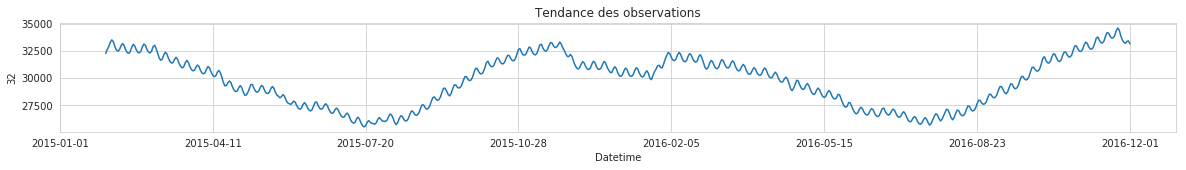

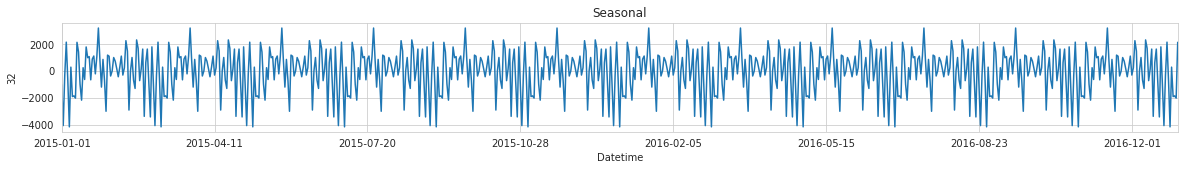

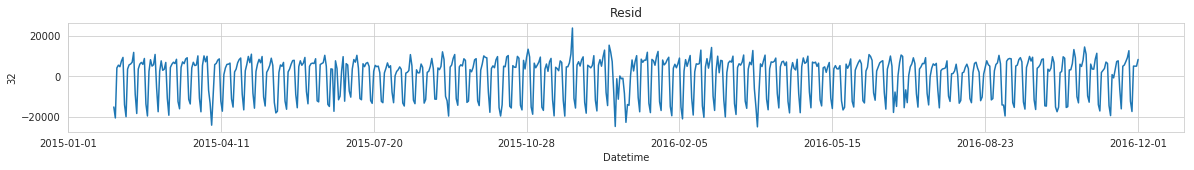

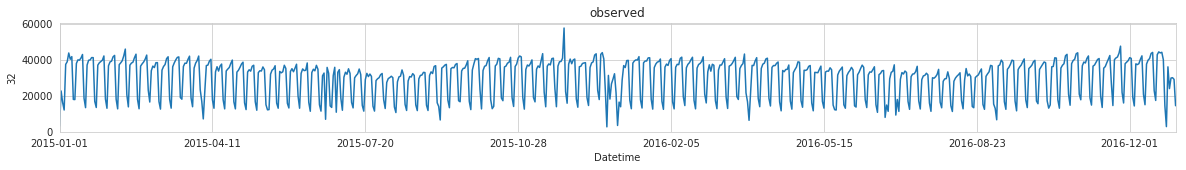

In [15]:
ts='32'
obs_dagg = obs.copy()
obs_dagg['Datetime'] = [i[:10] for i in obs_dagg['Datetime']]
obs_dagg = obs_dagg.groupby('Datetime').sum().loc['2015':'2017'].reset_index()
result_obs = seasonal_decompose(obs_dagg.set_index('Datetime')[ts], model='additive', freq=60)
fig,ax = plt.subplots(figsize=(20,2))
result_obs.trend.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('Tendance des observations')
plt.show()

fig,ax = plt.subplots(figsize=(20,2))
result_obs.seasonal.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('Seasonal')
plt.show()

fig,ax = plt.subplots(figsize=(20,2))
result_obs.resid.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('Resid')
plt.show()

fig,ax = plt.subplots(figsize=(20,2))
result_obs.observed.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('observed')
plt.show()

In [16]:
from statsmodels.tsa import arima_model 
ytrain = result_obs.trend.to_frame().dropna().values

model = arima_model.ARIMA(ytrain, order=(50,0,0))
model = model.fit(disp=5,max_iter=100)

KeyboardInterrupt: 

In [ ]:
ypred = model.predict(start = len(ytrain), end = len(ytrain)+400)

In [ ]:
fig,ax = plt.subplots(figsize = (20,2))
plt.plot(np.arange(0,len(ytrain)),ytrain)
plt.plot(np.arange(len(ytrain), len(ytrain)+len(ypred)), ypred)
plt.show()

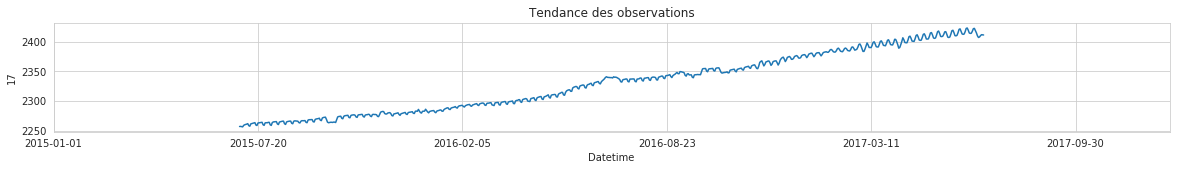

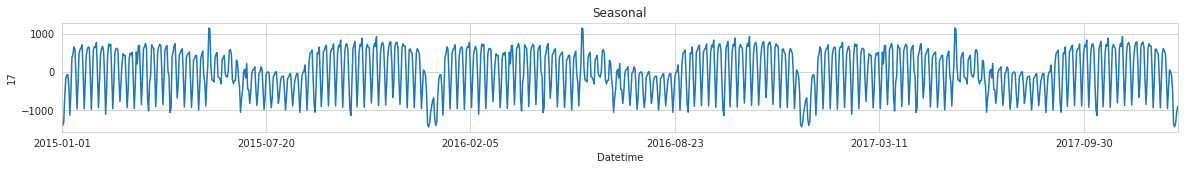

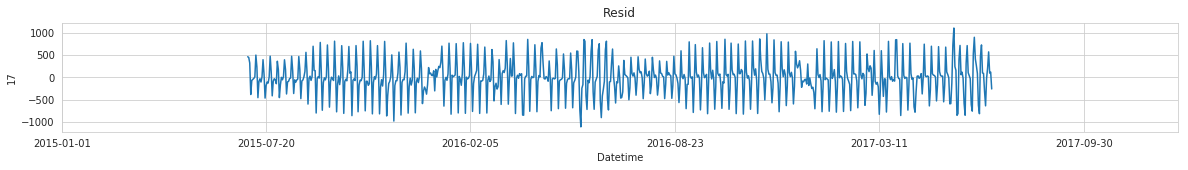

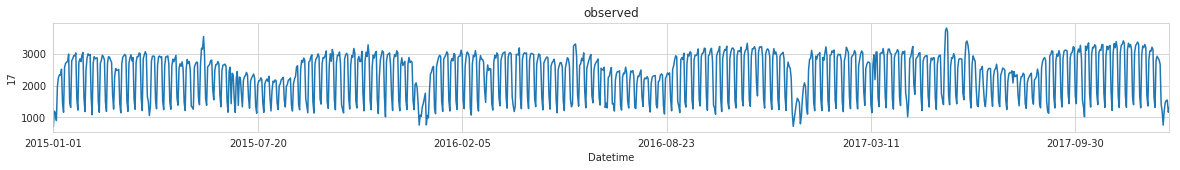

In [53]:
obs_dagg = obs.copy()
obs_dagg['Datetime'] = [i[:10] for i in obs_dagg['Datetime']]
obs_dagg = obs_dagg.groupby('Datetime').sum().loc['2015':'2018'].reset_index()
result_obs = seasonal_decompose(obs_dagg.set_index('Datetime')[ts], model='additive', freq=365)
fig,ax = plt.subplots(figsize=(20,2))
result_obs.trend.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('Tendance des observations')
plt.show()

fig,ax = plt.subplots(figsize=(20,2))
result_obs.seasonal.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('Seasonal')
plt.show()

fig,ax = plt.subplots(figsize=(20,2))
result_obs.resid.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('Resid')
plt.show()

fig,ax = plt.subplots(figsize=(20,2))
result_obs.observed.plot(ax=ax, legend = False)
plt.ylabel(ts)
plt.title('observed')
plt.show()